## Imports

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import datetime
warnings.filterwarnings('ignore')
#print(sns.__version__)

In [2]:
#Read file into a DataFrame and print head.
xword_data = pd.ExcelFile('../data/NYT_XWord_data.xlsx', engine='openpyxl')
print(xword_data.sheet_names)

['Sheet1']


In [3]:
df1 = xword_data.parse('Sheet1')

In [ ]:
df1.head(35)

In [ ]:
df1.info()

## Data Cleaning and Global Median Solver Feature Creation
A few generally useful operations for the exploratory analysis of the global median solver 

In [ ]:
# Delete weird columns at the back end of the imported data
#df2 = df1.drop(columns=df1.columns[-6:], axis=1)

In [4]:
# Drop other columns that, while potentially useful for predictive modeling, aren't necessary for the exploratory data analysis. Also drop columns specific to the individual solvers (IS1 and IS2)
df2 = df1.drop(['Difficulty', '1st_Constructor', '1st_Constuctor_Gender', '1st_Constructor_Puzzle_N', '1st_Constructor_Debut', '1st_Constructor_Scrabble_Avg', '1st_Constructor_Fresh%_Avg', '2nd_Constructor', '2nd_Constuctor_Gender', '2nd_Constructor_Puzzle_N', '2nd_Constructor_Debut', '2nd_Constructor_Scrabble_Avg', '2nd_Constructor_Fresh%_Avg', '3rd_Constructor', '3rd_Constuctor_Gender', '3rd_Constructor_Puzzle_N', '3rd_Constructor_Debut', '3rd_Constructor_Scrabble_Avg', '3rd_Constructor_Fresh%_Avg', 'Spans', '2_Stacks', '3_4_Stacks', 'Mirror_Sym', 'UD_Sym', 'Asym', 'Supersym', '90_180_Rot_Sym', 'LR_UD_Sym', 'Diag_Sym', 'Black_Square_Fill','Outside_Grid', 'Unchecked_Sq','Uniclue','Duplicate_Answers','Quantum', 'Completed_Date (IS1)', 'Completed_Date (IS2)', 'Time (s) (IS1)', 'Time (s) (IS2)'], axis=1)

In [5]:
# Rename a column for brevity and clarity
df2.rename(columns={'Constructors(by seniority)': 'Constructors'}, inplace=True)

In [6]:
# It will be useful generally to have puzzle dates as strings in other columns along with the datetimes 
df2['P_Date_str'] = df2['Puzzle_Date'].dt.strftime('%Y-%m-%d') #we want datetime as a string to index into here

In [7]:
# Convert global median solve times per puzzle to minutes and drop times in seconds
df2["GMST(m)"] = df2["Global_Median_Solver_Time(s)"]/60  #GMST = Global Median solve times
df2.drop(['Global_Median_Solver_Time(s)'], axis=1, inplace=True)

In [8]:
# Calculate 10-puzzle moving average for global solver raw solve times, within Day of Week
# Unlike for Individual Solvers (see below), we do not have completion dates for median solver per puzzle. It is therefor assumed that completion date tracks with puzzle date (obviously not always going to be true, but approximates true closely enough for our purposes)
df2 = df2.sort_values(by=['Day_of_Week','Puzzle_Date'], ascending = True)
df2['GMST(m)_10p_MA'] = df2.groupby('Day_of_Week')['GMST(m)'].transform(lambda x: x.rolling(10, 3).mean().reset_index(drop=True))
df2 = df2.sort_values(by=['Day_of_Week','Puzzle_Date'], ascending = False)

In [9]:
# Calculate 20-puzzle moving average for global solver raw solve times, within Day of Week
# Unlike for Individual Solvers (see below), we do not have completion dates for median solver per puzzle. It is therefor assumed that completion date tracks with puzzle date (obviously not always going to be true, but approximates true closely enough for our purposes)
df2 = df2.sort_values(by=['Day_of_Week','Puzzle_Date'], ascending = True)
df2['GMST(m)_20p_MA'] = df2.groupby('Day_of_Week')['GMST(m)'].transform(lambda x: x.rolling(20, 3).mean().reset_index(drop=True))
df2 = df2.sort_values(by=['Day_of_Week','Puzzle_Date'], ascending = False)

In [10]:
# It will be useful to have year of puzzle issue in a separate column for analysis below
df2['P_Yr'] = df2['Puzzle_Date'].dt.to_period('Y')
df2['P_Yr'].value_counts()

2020    366
2021    365
2019    365
2022    365
2018    365
2023    361
Freq: A-DEC, Name: P_Yr, dtype: int64

In [11]:
# Also, a column indicating pre-2023 puzzle issue date or 2023 puzzle issue date
df2.loc[(df2["P_Yr"] == "2023"), "2023_puzzle"] = 1 #2023 puzzle issue date
df2.loc[(df2["P_Yr"] != "2023"), "2023_puzzle"] = 0 #pre-2023 puzzle issue date

In [12]:
# Rename a few columns for brevity and clarity
df2.rename(columns={'Median_Solver%_AVG_PM':'Diff%_from_10pMA(GMS)', 'Day_of_Week': 'DOW', 'Puzzle_Date': 'P_Date'}, inplace=True)

In [13]:
# A numerical column for puzzle day that starts with Sunday and ends with Saturday
df2.loc[(df2["DOW"] == "Sunday"), "DOW_num"] = 1 
df2.loc[(df2["DOW"] == "Monday"), "DOW_num"] = 2
df2.loc[(df2["DOW"] == "Tuesday"), "DOW_num"] = 3
df2.loc[(df2["DOW"] == "Wednesday"), "DOW_num"] = 4
df2.loc[(df2["DOW"] == "Thursday"), "DOW_num"] = 5
df2.loc[(df2["DOW"] == "Friday"), "DOW_num"] = 6
df2.loc[(df2["DOW"] == "Saturday"), "DOW_num"] = 7

In [14]:
# Move new columns to logical places in dataframe
col = df2.pop('P_Date_str')
df2.insert(1, col.name, col)

col = df2.pop('P_Yr')
df2.insert(2, col.name, col)

col = df2.pop('2023_puzzle')
df2.insert(3, col.name, col)

col = df2.pop('DOW')
df2.insert(4, col.name, col)

col = df2.pop('DOW_num')
df2.insert(5, col.name, col)

col = df2.pop('GMST(m)')
df2.insert(10, col.name, col)

col = df2.pop('GMST(m)_10p_MA')
df2.insert(11, col.name, col)

col = df2.pop('GMST(m)_20p_MA')
df2.insert(12, col.name, col)

In [ ]:
df2.info()

In [15]:
# Computes mean global median solve times per puzzle day, per year. These will be used later on when making difficulty of "schedule" adjustments to past individual solver performance
mean_Sat_2023 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
mean_Sat_2022 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
mean_Sat_2021 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
mean_Sat_2020 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
mean_Sat_2019 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
mean_Sat_2018 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

mean_Fri_2023 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
mean_Fri_2022 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
mean_Fri_2021 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
mean_Fri_2020 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
mean_Fri_2019 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
mean_Fri_2018 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

mean_Thu_2023 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
mean_Thu_2022 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
mean_Thu_2021 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
mean_Thu_2020 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
mean_Thu_2019 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
mean_Thu_2018 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

mean_Wed_2023 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
mean_Wed_2022 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
mean_Wed_2021 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
mean_Wed_2020 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
mean_Wed_2019 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
mean_Wed_2018 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

mean_Tue_2023 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
mean_Tue_2022 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
mean_Tue_2021 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
mean_Tue_2020 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
mean_Tue_2019 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
mean_Tue_2018 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

mean_Mon_2023 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
mean_Mon_2022 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
mean_Mon_2021 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
mean_Mon_2020 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
mean_Mon_2019 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
mean_Mon_2018 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

mean_Sun_2023 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
mean_Sun_2022 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
mean_Sun_2021 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
mean_Sun_2020 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
mean_Sun_2019 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
mean_Sun_2018 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()


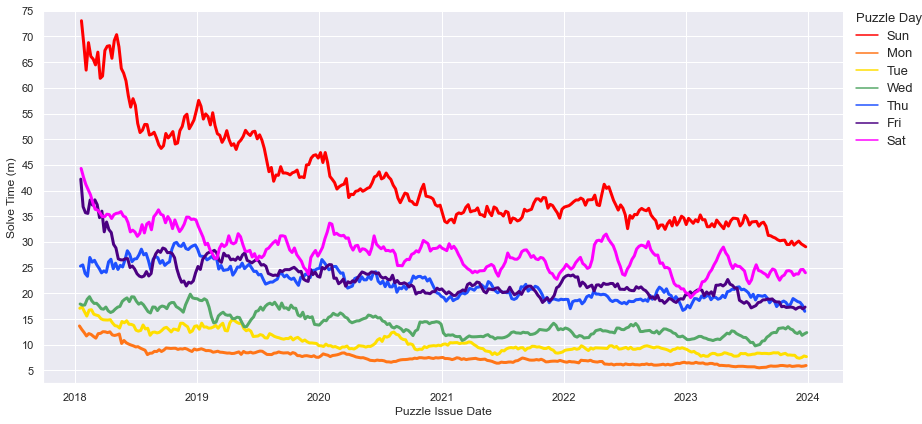

In [16]:
# Plot 10-puzzle moving average of Global Median Solve Times by Day of Week

sns.set(font_scale=1)

p = sns.relplot(
    data=df2, marker = "", x="P_Date", y="GMST(m)_10p_MA", hue="DOW", hue_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], height=6, aspect=2, palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "indigo", "fuchsia"],
    kind="line", linewidth=3 
).set(title="", 
    ylabel="Solve Time (m)",
    xlabel= "Puzzle Issue Date", ylim=[2.5, 75], yticks = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
)

# Modify legend
leg = p._legend
leg.set_title("Puzzle Day")
leg.set_bbox_to_anchor([.88, .975])  # coordinates of lower left of bounding box
leg.get_title().set_fontsize(13)
leg._loc = 2  # if required you can set the loc
leg.get_texts()[0].set_fontsize(13)
leg.get_texts()[0].set_text('Sun')
leg.get_texts()[1].set_fontsize(13)
leg.get_texts()[1].set_text('Mon')
leg.get_texts()[2].set_fontsize(13)
leg.get_texts()[2].set_text('Tue')
leg.get_texts()[3].set_fontsize(13)
leg.get_texts()[3].set_text('Wed')
leg.get_texts()[4].set_fontsize(13)
leg.get_texts()[4].set_text('Thu')
leg.get_texts()[5].set_fontsize(13)
leg.get_texts()[5].set_text('Fri')
leg.get_texts()[6].set_fontsize(13)
leg.get_texts()[6].set_text('Sat')
leg._legend_box.align = "left"  # or left, or center

In [ ]:
df2.info()

In [ ]:
# Checkpoint
df2.to_csv('../data/df2.csv', index=False)

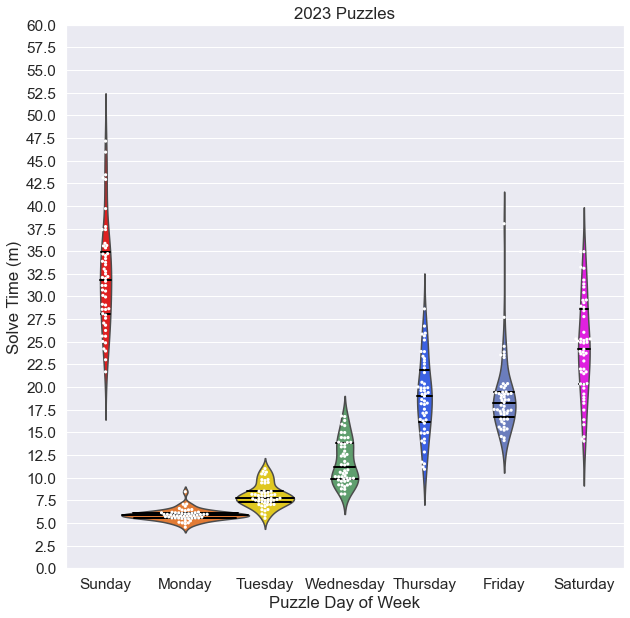

In [17]:
# Violin plots with swarm plot overlay by puzzle day -2023 only
#Note: Unlike with indvidual solver data, we do not have puzzle completion data for global median solver. 
#It is assumed therefore that puzzles were completed in the same sequence of puzzle issue (which is almost certainly approximately accurate at population level)
sns.set(font_scale=1.4)

GMS_2023 = df2.loc[df2["P_Date_str"].str.contains("2023")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "GMST(m)",data=GMS_2023 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(GMS_2023['DOW'], GMS_2023['GMST(m)'], width = 1.6, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 60)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60])
ax.set_title("2023 Puzzles")
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

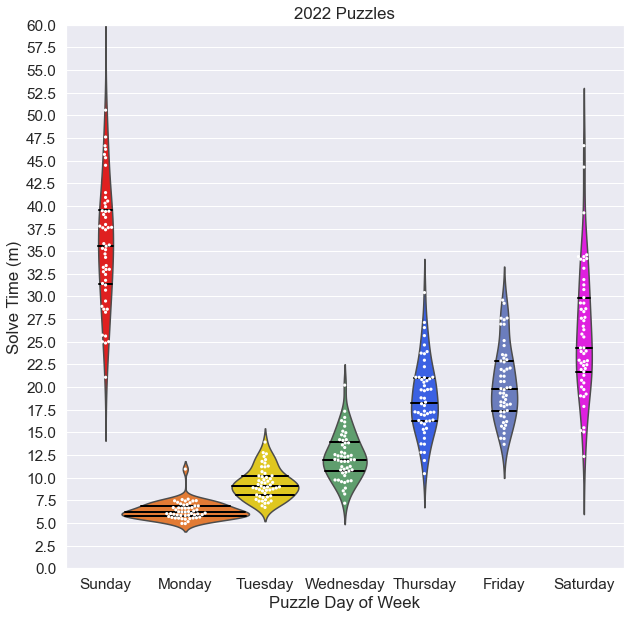

In [18]:
# Violin plots with swarm plot overlay by puzzle day -2022 only
#Note: Unlike with indvidual solver data, we do not have puzzle completion data for global median solver. 
#It is assumed therefore that puzzles were completed in the same sequence of puzzle issue (which is almost certainly approximately accurate at population level)
sns.set(font_scale=1.4)

GMS_2022 = df2.loc[df2["P_Date_str"].str.contains("2022")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "GMST(m)",data=GMS_2022 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(GMS_2022['DOW'], GMS_2022['GMST(m)'], width = 1.6, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 60)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5,60])
ax.set_title("2022 Puzzles")
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

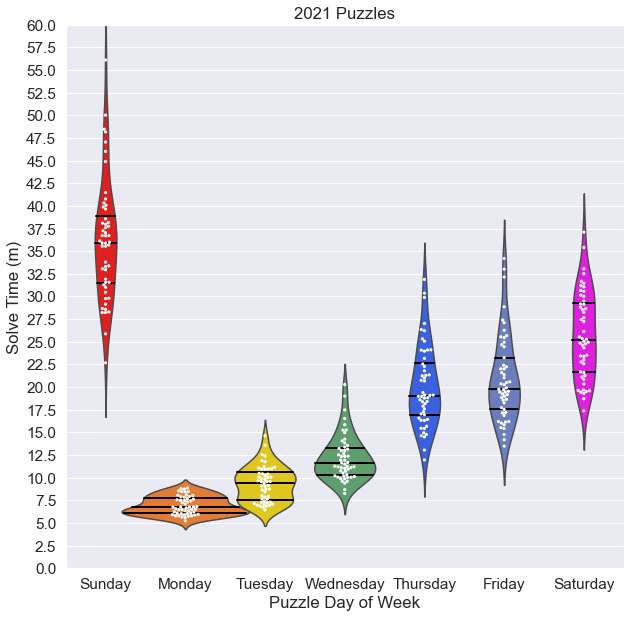

In [19]:
# Violin plots with swarm plot overlay by puzzle day -2021 only
#Note: Unlike with indvidual solver data, we do not have puzzle completion data for global median solver. 
#It is assumed therefore that puzzles were completed in the same sequence of puzzle issue (which is almost certainly approximately accurate at population level)
sns.set(font_scale=1.4)

GMS_2021 = df2.loc[df2["P_Date_str"].str.contains("2021")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "GMST(m)",data=GMS_2021 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(GMS_2021['DOW'], GMS_2021['GMST(m)'], width = 1.6, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 60)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60])
ax.set_title("2021 Puzzles")
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

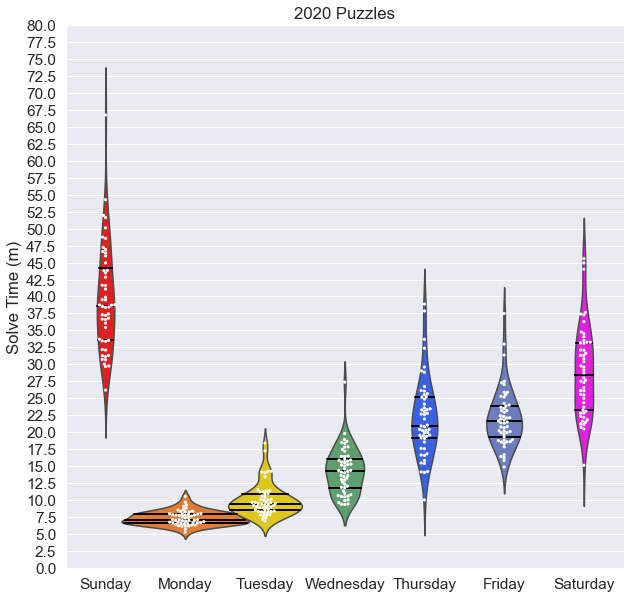

In [20]:
# Violin plots with swarm plot overlay by puzzle day -2020 only
#Note: Unlike with indvidual solver data, we do not have puzzle completion data for global median solver. 
#It is assumed therefore that puzzles were completed in the same sequence of puzzle issue (which is almost certainly approximately accurate at population level)
sns.set(font_scale=1.4)

GMS_2020 = df2.loc[df2["P_Date_str"].str.contains("2020")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "GMST(m)",data=GMS_2020 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(GMS_2020['DOW'], GMS_2020['GMST(m)'], width = 1.6, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 80)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5,65,67.5,70,72.5,75,77.5,80])
ax.set_title("2020 Puzzles")
ax.set_xlabel("")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

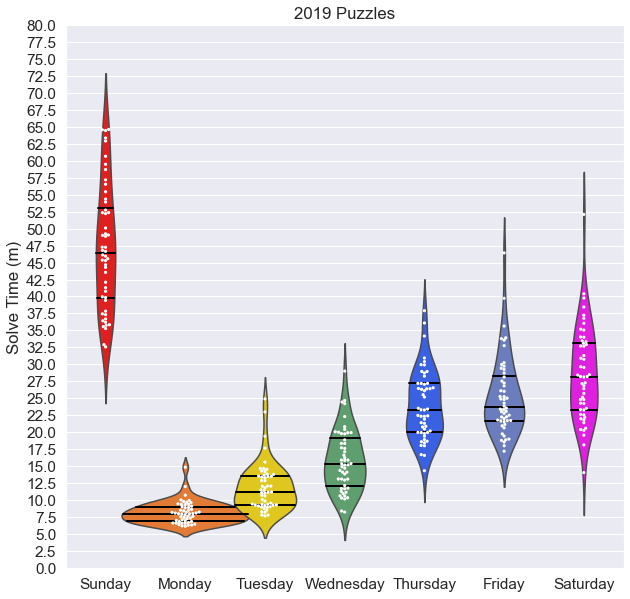

In [21]:
# Violin plots with swarm plot overlay by puzzle day 2019 solves only

GMS_2019 = df2.loc[df2["P_Date_str"].str.contains("2019")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "GMST(m)",data=GMS_2019 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(GMS_2019['DOW'], GMS_2019['GMST(m)'], width = 1.6, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 60)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5, 65, 67.5, 70, 72.5, 75, 77.5, 80])
ax.set_title("2019 Puzzles")
ax.set_xlabel("")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

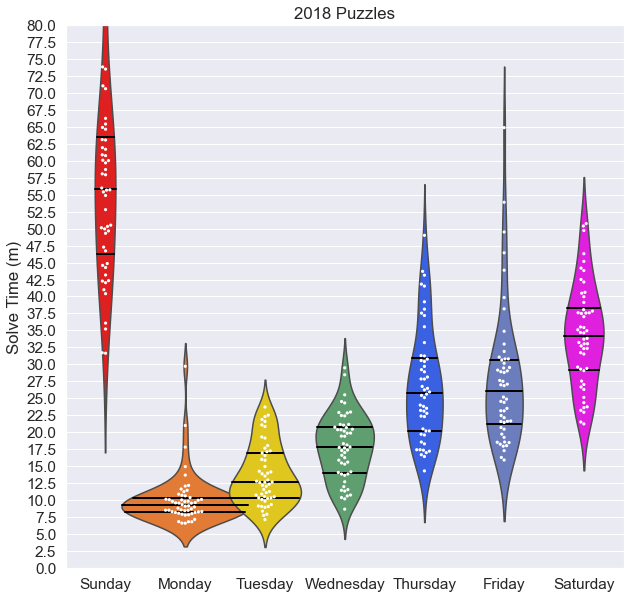

In [22]:
# Violin plots with swarm plot overlay by puzzle day 2018 solves only

GMS_2018 = df2.loc[df2["P_Date_str"].str.contains("2018")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "GMST(m)",data=GMS_2018 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(GMS_2018['DOW'], GMS_2018['GMST(m)'], width = 1.6, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 80)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5, 65, 67.5, 70, 72.5, 75, 77.5, 80])
ax.set_title("2018 Puzzles")
ax.set_xlabel("")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

### Constructor Analysis
Which constructors does the global median solver struggle against? Which ones does the global median solver do well against? This analysis is with respect to average deviation from day-specific 10-puzzle moving average per constructor/constructor team. 

In [26]:
# Make a deep copy of df2
df_GMS = df2.copy()

In [27]:
#Get stats for Global Median Solver
constructor_avgs_GMS = df_GMS.groupby(['Constructors'])['Diff%_from_10pMA(GMS)'].agg(constructor_mean_GMS=(np.mean), puzzle_count_GMS=(np.count_nonzero))
constructor_avgs_GMS["constructor_mean_GMS"] = constructor_avgs_GMS["constructor_mean_GMS"].round(2)

puzzle_min_threshold = 5 #min number of puzzles in sample for constructor/constructor team to be kept in the analysis 

# Pare down to only constructor(s) with at least n puzzles for which IS1 has completed
constructor_avgs_filter = constructor_avgs_GMS.loc[constructor_avgs_GMS['puzzle_count_GMS'] >= puzzle_min_threshold] 

In [28]:
constructor_avgs_filter.to_csv('../data/constructor_avgs_filter.csv', index=True)

PermissionError: [Errno 13] Permission denied: '../data/constructor_avgs_filter.csv'

In [31]:
constructor_avgs_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115 entries, Adam Aaronson to Zhouqin Burnikel
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   constructor_mean_GMS  115 non-null    float64
 1   puzzle_count_GMS      115 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 7.7+ KB


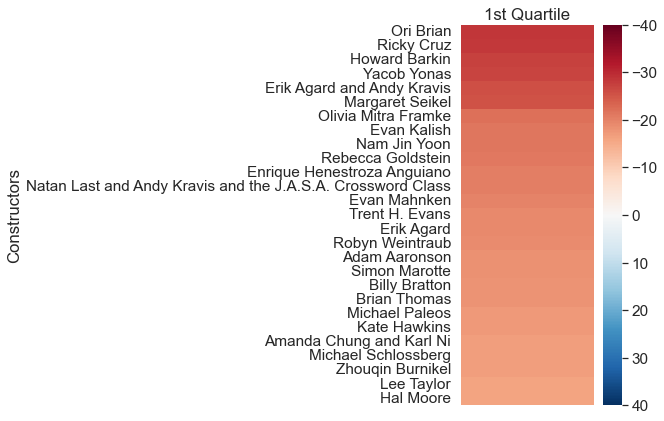

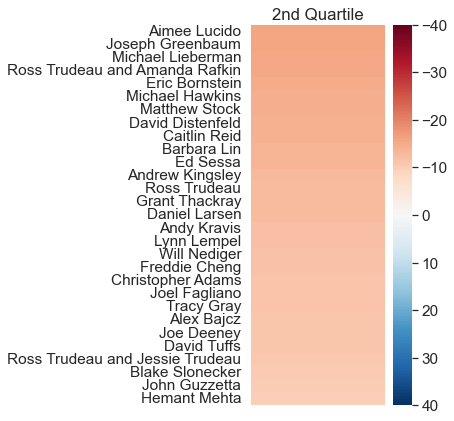

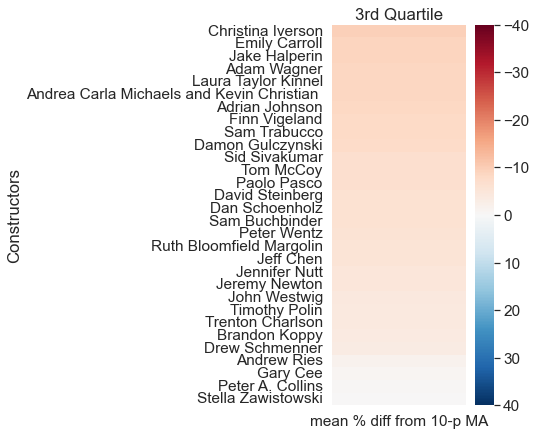

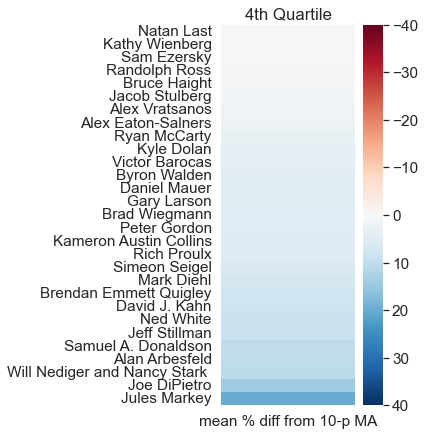

In [44]:
# Construct Heat Map sorted by fastest constructor relative to Individual solver 10 puzzle moving average to slowest

#Remove puzzle ns columns and sort for heatmapping
avgs = constructor_avgs_filter[["constructor_mean_GMS"]]
avgs = avgs.sort_values(by=['constructor_mean_GMS'], ascending = True)

first_q_end = int((len(avgs)/4)-1)
second_q_start = int(first_q_end)
second_q_end = int((len(avgs)/2)-1)
third_q_start = int(second_q_end)
third_q_end = int(len(avgs) - (len(avgs)/4))
fourth_q_start = int(len(avgs) - (len(avgs)/4))
fourth_q_end = int(len(avgs))

first_q = avgs[0:first_q_end]
second_q = avgs[second_q_start:second_q_end]
third_q = avgs[third_q_start:third_q_end]
fourth_q = avgs[fourth_q_start:fourth_q_end]

first_q = first_q.sort_values(by=['constructor_mean_GMS'], ascending = True)
plt.figure(figsize=(3,7))
#sns.set(font_scale=1.2)
ax = sns.heatmap(first_q, xticklabels=[''], cmap="RdBu", vmin=-40, vmax=40, yticklabels=True)
plt.gcf().axes[1].invert_yaxis() #flip color bar to show fastest at the top
plt.title("1st Quartile")
plt.show()

second_q = second_q.sort_values(by=['constructor_mean_GMS'], ascending = True)
plt.figure(figsize=(3,7))
#sns.set(font_scale=1.2)
ax = sns.heatmap(second_q, xticklabels=[''], cmap="RdBu", vmin=-40, vmax=40, yticklabels=True)
plt.gcf().axes[1].invert_yaxis() #flip color bar to show fastest at the top
ax.set(ylabel='', xlabel='');
plt.title("2nd Quartile")
plt.show()

third_q = third_q.sort_values(by=['constructor_mean_GMS'], ascending = True)
plt.figure(figsize=(3,7))
#sns.set(font_scale=1.2)
ax = sns.heatmap(third_q, xticklabels=['mean % diff from 10-p MA'], cmap="RdBu", vmin=-40, vmax=40, yticklabels=True)
plt.gcf().axes[1].invert_yaxis() #flip color bar to show fastest at the top
plt.title("3rd Quartile")
plt.show()

fourth_q = fourth_q.sort_values(by=['constructor_mean_GMS'], ascending = True)
plt.figure(figsize=(3,7))
#sns.set(font_scale=1.2)
ax = sns.heatmap(fourth_q, xticklabels=['mean % diff from 10-p MA'], cmap="RdBu", vmin=-40, vmax=40, yticklabels=True)
plt.gcf().axes[1].invert_yaxis() #flip color bar to show fastest at the top
ax.set(ylabel='', xlabel='');
plt.title("4th Quartile")
plt.show()


In [30]:
#constructor_avgs_filter[["constructor_mean_IS"]].agg(['min', 'max'])
constructor_avgs_filter[["constructor_mean_GMS"]].agg(['min', 'max'])

constructor_mean_GMS
min                -28.57
max                 20.00

### Puzzle and Answer-Features Correlation to Solve Times

Create a few new features for day-specific weighted global median solver solver past performance to use as frame of reference for the puzzle and answer-specific correlations

In [45]:
#GMS_pds_l10_dw
#Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for the global median solver over the previous 10 puzzles

df_GMS = df_GMS.sort_values(by=['DOW', 'P_Date'], ascending = False)

w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

df_GMS["GMS_pds_l10_dw_1"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1)*w[0]
df_GMS["GMS_pds_l10_dw_2"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2)*w[1]
df_GMS["GMS_pds_l10_dw_3"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3)*w[2]
df_GMS["GMS_pds_l10_dw_4"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4)*w[3]
df_GMS["GMS_pds_l10_dw_5"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5)*w[4]
df_GMS["GMS_pds_l10_dw_6"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6)*w[5]
df_GMS["GMS_pds_l10_dw_7"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7)*w[6]
df_GMS["GMS_pds_l10_dw_8"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8)*w[7]
df_GMS["GMS_pds_l10_dw_9"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9)*w[8]
df_GMS["GMS_pds_l10_dw_10"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10)*w[9]

df_GMS["GMS_pds_l10_dw_1_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1))*w[0]
df_GMS["GMS_pds_l10_dw_2_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2))*w[1]
df_GMS["GMS_pds_l10_dw_3_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3))*w[2]
df_GMS["GMS_pds_l10_dw_4_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4))*w[3]
df_GMS["GMS_pds_l10_dw_5_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5))*w[4]
df_GMS["GMS_pds_l10_dw_6_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6))*w[5]
df_GMS["GMS_pds_l10_dw_7_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7))*w[6]
df_GMS["GMS_pds_l10_dw_8_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8))*w[7]
df_GMS["GMS_pds_l10_dw_9_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9))*w[8]
df_GMS["GMS_pds_l10_dw_10_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10))*w[9]

df_GMS["GMS_pds_l10_ws"] = df_GMS[["GMS_pds_l10_dw_1", "GMS_pds_l10_dw_2", "GMS_pds_l10_dw_3", "GMS_pds_l10_dw_4", "GMS_pds_l10_dw_5", "GMS_pds_l10_dw_6", "GMS_pds_l10_dw_7", "GMS_pds_l10_dw_8", "GMS_pds_l10_dw_9", "GMS_pds_l10_dw_10"]].sum(axis=1)
df_GMS["GMS_pds_l10_ws_ct"] = df_GMS[["GMS_pds_l10_dw_1_ct", "GMS_pds_l10_dw_2_ct", "GMS_pds_l10_dw_3_ct", "GMS_pds_l10_dw_4_ct", "GMS_pds_l10_dw_5_ct", "GMS_pds_l10_dw_6_ct", "GMS_pds_l10_dw_7_ct", "GMS_pds_l10_dw_8_ct", "GMS_pds_l10_dw_9_ct", "GMS_pds_l10_dw_10_ct"]].sum(axis=1)
df_GMS["GMS_pds_l10_dw"] = df_GMS["GMS_pds_l10_ws"]/df_GMS["GMS_pds_l10_ws_ct"]

# Deleting transient columns
df_GMS = df_GMS.drop(["GMS_pds_l10_dw_1", "GMS_pds_l10_dw_2", "GMS_pds_l10_dw_3", "GMS_pds_l10_dw_4", "GMS_pds_l10_dw_5", "GMS_pds_l10_dw_6", "GMS_pds_l10_dw_7", "GMS_pds_l10_dw_8", "GMS_pds_l10_dw_9", "GMS_pds_l10_dw_10", "GMS_pds_l10_dw_1_ct", "GMS_pds_l10_dw_2_ct", "GMS_pds_l10_dw_3_ct", "GMS_pds_l10_dw_4_ct", "GMS_pds_l10_dw_5_ct", "GMS_pds_l10_dw_6_ct", "GMS_pds_l10_dw_7_ct", "GMS_pds_l10_dw_8_ct", "GMS_pds_l10_dw_9_ct", "GMS_pds_l10_dw_10_ct", "GMS_pds_l10_ws", "GMS_pds_l10_ws_ct"], axis = 1)

In [46]:
#GMS_pds_l20_dw
#Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for the global median solver over the previous 20 puzzles

df_GMS = df_GMS.sort_values(by=['DOW', 'P_Date'], ascending = False)

w = [20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

df_GMS["GMS_pds_l20_dw_1"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1)*w[0]
df_GMS["GMS_pds_l20_dw_2"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2)*w[1]
df_GMS["GMS_pds_l20_dw_3"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3)*w[2]
df_GMS["GMS_pds_l20_dw_4"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4)*w[3]
df_GMS["GMS_pds_l20_dw_5"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5)*w[4]
df_GMS["GMS_pds_l20_dw_6"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6)*w[5]
df_GMS["GMS_pds_l20_dw_7"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7)*w[6]
df_GMS["GMS_pds_l20_dw_8"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8)*w[7]
df_GMS["GMS_pds_l20_dw_9"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9)*w[8]
df_GMS["GMS_pds_l20_dw_10"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10)*w[9]
df_GMS["GMS_pds_l20_dw_11"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-11)*w[10]
df_GMS["GMS_pds_l20_dw_12"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-12)*w[11]
df_GMS["GMS_pds_l20_dw_13"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-13)*w[12]
df_GMS["GMS_pds_l20_dw_14"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-14)*w[13]
df_GMS["GMS_pds_l20_dw_15"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-15)*w[14]
df_GMS["GMS_pds_l20_dw_16"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-16)*w[15]
df_GMS["GMS_pds_l20_dw_17"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-17)*w[16]
df_GMS["GMS_pds_l20_dw_18"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-18)*w[17]
df_GMS["GMS_pds_l20_dw_19"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-19)*w[18]
df_GMS["GMS_pds_l20_dw_20"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-20)*w[19]

df_GMS["GMS_pds_l20_dw_1_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1))*w[0]
df_GMS["GMS_pds_l20_dw_2_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2))*w[1]
df_GMS["GMS_pds_l20_dw_3_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3))*w[2]
df_GMS["GMS_pds_l20_dw_4_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4))*w[3]
df_GMS["GMS_pds_l20_dw_5_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5))*w[4]
df_GMS["GMS_pds_l20_dw_6_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6))*w[5]
df_GMS["GMS_pds_l20_dw_7_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7))*w[6]
df_GMS["GMS_pds_l20_dw_8_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8))*w[7]
df_GMS["GMS_pds_l20_dw_9_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9))*w[8]
df_GMS["GMS_pds_l20_dw_10_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10))*w[9]
df_GMS["GMS_pds_l20_dw_11_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-11)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-11))*w[10]
df_GMS["GMS_pds_l20_dw_12_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-12)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-12))*w[11]
df_GMS["GMS_pds_l20_dw_13_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-13)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-13))*w[12]
df_GMS["GMS_pds_l20_dw_14_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-14)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-14))*w[13]
df_GMS["GMS_pds_l20_dw_15_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-15)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-15))*w[14]
df_GMS["GMS_pds_l20_dw_16_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-16)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-16))*w[15]
df_GMS["GMS_pds_l20_dw_17_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-17)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-17))*w[16]
df_GMS["GMS_pds_l20_dw_18_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-18)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-18))*w[17]
df_GMS["GMS_pds_l20_dw_19_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-19)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-19))*w[18]
df_GMS["GMS_pds_l20_dw_20_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-20)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-20))*w[19]

df_GMS["GMS_pds_l20_ws"] = df_GMS[["GMS_pds_l20_dw_1", "GMS_pds_l20_dw_2", "GMS_pds_l20_dw_3", "GMS_pds_l20_dw_4", "GMS_pds_l20_dw_5", "GMS_pds_l20_dw_6", "GMS_pds_l20_dw_7", "GMS_pds_l20_dw_8", "GMS_pds_l20_dw_9", "GMS_pds_l20_dw_10", "GMS_pds_l20_dw_11", "GMS_pds_l20_dw_12", "GMS_pds_l20_dw_13", "GMS_pds_l20_dw_14", "GMS_pds_l20_dw_15", "GMS_pds_l20_dw_16", "GMS_pds_l20_dw_17", "GMS_pds_l20_dw_18", "GMS_pds_l20_dw_19", "GMS_pds_l20_dw_20"]].sum(axis=1)
df_GMS["GMS_pds_l20_ws_ct"] = df_GMS[["GMS_pds_l20_dw_1_ct", "GMS_pds_l20_dw_2_ct", "GMS_pds_l20_dw_3_ct", "GMS_pds_l20_dw_4_ct", "GMS_pds_l20_dw_5_ct", "GMS_pds_l20_dw_6_ct", "GMS_pds_l20_dw_7_ct", "GMS_pds_l20_dw_8_ct", "GMS_pds_l20_dw_9_ct", "GMS_pds_l20_dw_10_ct", "GMS_pds_l20_dw_11_ct", "GMS_pds_l20_dw_12_ct", "GMS_pds_l20_dw_13_ct", "GMS_pds_l20_dw_14_ct", "GMS_pds_l20_dw_15_ct", "GMS_pds_l20_dw_16_ct", "GMS_pds_l20_dw_17_ct", "GMS_pds_l20_dw_18_ct", "GMS_pds_l20_dw_19_ct", "GMS_pds_l20_dw_20_ct"]].sum(axis=1)
df_GMS["GMS_pds_l20_dw"] = df_GMS["GMS_pds_l20_ws"]/df_GMS["GMS_pds_l20_ws_ct"]

# Deleting transient columns
df_GMS = df_GMS.drop(["GMS_pds_l20_dw_1", "GMS_pds_l20_dw_2", "GMS_pds_l20_dw_3", "GMS_pds_l20_dw_4", "GMS_pds_l20_dw_5", "GMS_pds_l20_dw_6", "GMS_pds_l20_dw_7", "GMS_pds_l20_dw_8", "GMS_pds_l20_dw_9", "GMS_pds_l20_dw_10", "GMS_pds_l20_dw_11", "GMS_pds_l20_dw_12", "GMS_pds_l20_dw_13", "GMS_pds_l20_dw_14", "GMS_pds_l20_dw_15", "GMS_pds_l20_dw_16", "GMS_pds_l20_dw_17", "GMS_pds_l20_dw_18", "GMS_pds_l20_dw_19", "GMS_pds_l20_dw_20", "GMS_pds_l20_dw_1_ct", "GMS_pds_l20_dw_2_ct", "GMS_pds_l20_dw_3_ct", "GMS_pds_l20_dw_4_ct", "GMS_pds_l20_dw_5_ct", "GMS_pds_l20_dw_6_ct", "GMS_pds_l20_dw_7_ct", "GMS_pds_l20_dw_8_ct", "GMS_pds_l20_dw_9_ct", "GMS_pds_l20_dw_10_ct", "GMS_pds_l20_dw_11_ct", "GMS_pds_l20_dw_12_ct", "GMS_pds_l20_dw_13_ct", "GMS_pds_l20_dw_14_ct", "GMS_pds_l20_dw_15_ct", "GMS_pds_l20_dw_16_ct", "GMS_pds_l20_dw_17_ct", "GMS_pds_l20_dw_18_ct", "GMS_pds_l20_dw_19_ct", "GMS_pds_l20_dw_20_ct", "GMS_pds_l20_ws", "GMS_pds_l20_ws_ct"], axis = 1)

In [47]:
#GMS_pds_l10_nndw
#Provides NON decay-weighted(ndw), puzzle day-specific (pds) mean solve time performance for the individual solver over the previous 10 puzzles

df_GMS = df_GMS.sort_values(by=['DOW', 'P_Date'], ascending = False)

w = [1,1,1,1,1,1,1,1,1,1] #weight assigned to puzzle (equal for this variant)

df_GMS["GMS_pds_l10_ndw_1"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1)*w[0]
df_GMS["GMS_pds_l10_ndw_2"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2)*w[1]
df_GMS["GMS_pds_l10_ndw_3"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3)*w[2]
df_GMS["GMS_pds_l10_ndw_4"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4)*w[3]
df_GMS["GMS_pds_l10_ndw_5"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5)*w[4]
df_GMS["GMS_pds_l10_ndw_6"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6)*w[5]
df_GMS["GMS_pds_l10_ndw_7"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7)*w[6]
df_GMS["GMS_pds_l10_ndw_8"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8)*w[7]
df_GMS["GMS_pds_l10_ndw_9"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9)*w[8]
df_GMS["GMS_pds_l10_ndw_10"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10)*w[9]

df_GMS["GMS_pds_l10_ndw_1_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1))*w[0]
df_GMS["GMS_pds_l10_ndw_2_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2))*w[1]
df_GMS["GMS_pds_l10_ndw_3_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3))*w[2]
df_GMS["GMS_pds_l10_ndw_4_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4))*w[3]
df_GMS["GMS_pds_l10_ndw_5_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5))*w[4]
df_GMS["GMS_pds_l10_ndw_6_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6))*w[5]
df_GMS["GMS_pds_l10_ndw_7_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7))*w[6]
df_GMS["GMS_pds_l10_ndw_8_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8))*w[7]
df_GMS["GMS_pds_l10_ndw_9_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9))*w[8]
df_GMS["GMS_pds_l10_ndw_10_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10))*w[9]

df_GMS["GMS_pds_l10_ws"] = df_GMS[["GMS_pds_l10_ndw_1", "GMS_pds_l10_ndw_2", "GMS_pds_l10_ndw_3", "GMS_pds_l10_ndw_4", "GMS_pds_l10_ndw_5", "GMS_pds_l10_ndw_6", "GMS_pds_l10_ndw_7", "GMS_pds_l10_ndw_8", "GMS_pds_l10_ndw_9", "GMS_pds_l10_ndw_10"]].sum(axis=1)
df_GMS["GMS_pds_l10_ws_ct"] = df_GMS[["GMS_pds_l10_ndw_1_ct", "GMS_pds_l10_ndw_2_ct", "GMS_pds_l10_ndw_3_ct", "GMS_pds_l10_ndw_4_ct", "GMS_pds_l10_ndw_5_ct", "GMS_pds_l10_ndw_6_ct", "GMS_pds_l10_ndw_7_ct", "GMS_pds_l10_ndw_8_ct", "GMS_pds_l10_ndw_9_ct", "GMS_pds_l10_ndw_10_ct"]].sum(axis=1)
df_GMS["GMS_pds_l10_ndw"] = df_GMS["GMS_pds_l10_ws"]/df_GMS["GMS_pds_l10_ws_ct"]

# Deleting transient columns
df_GMS = df_GMS.drop(["GMS_pds_l10_ndw_1", "GMS_pds_l10_ndw_2", "GMS_pds_l10_ndw_3", "GMS_pds_l10_ndw_4", "GMS_pds_l10_ndw_5", "GMS_pds_l10_ndw_6", "GMS_pds_l10_ndw_7", "GMS_pds_l10_ndw_8", "GMS_pds_l10_ndw_9", "GMS_pds_l10_ndw_10", "GMS_pds_l10_ndw_1_ct", "GMS_pds_l10_ndw_2_ct", "GMS_pds_l10_ndw_3_ct", "GMS_pds_l10_ndw_4_ct", "GMS_pds_l10_ndw_5_ct", "GMS_pds_l10_ndw_6_ct", "GMS_pds_l10_ndw_7_ct", "GMS_pds_l10_ndw_8_ct", "GMS_pds_l10_ndw_9_ct", "GMS_pds_l10_ndw_10_ct", "GMS_pds_l10_ws", "GMS_pds_l10_ws_ct"], axis = 1)

In [48]:
#GMS_pds_l20_ndw
#Provides NON decay-weighted(ndw), puzzle day-specific (pds) mean solve time performance for the global median solver over the previous 20 puzzles

df_GMS = df_GMS.sort_values(by=['DOW', 'P_Date'], ascending = False)

w = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] #weight assigned to puzzle

df_GMS["GMS_pds_l20_ndw_1"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1)*w[0]
df_GMS["GMS_pds_l20_ndw_2"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2)*w[1]
df_GMS["GMS_pds_l20_ndw_3"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3)*w[2]
df_GMS["GMS_pds_l20_ndw_4"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4)*w[3]
df_GMS["GMS_pds_l20_ndw_5"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5)*w[4]
df_GMS["GMS_pds_l20_ndw_6"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6)*w[5]
df_GMS["GMS_pds_l20_ndw_7"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7)*w[6]
df_GMS["GMS_pds_l20_ndw_8"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8)*w[7]
df_GMS["GMS_pds_l20_ndw_9"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9)*w[8]
df_GMS["GMS_pds_l20_ndw_10"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10)*w[9]
df_GMS["GMS_pds_l20_ndw_11"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-11)*w[10]
df_GMS["GMS_pds_l20_ndw_12"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-12)*w[11]
df_GMS["GMS_pds_l20_ndw_13"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-13)*w[12]
df_GMS["GMS_pds_l20_ndw_14"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-14)*w[13]
df_GMS["GMS_pds_l20_ndw_15"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-15)*w[14]
df_GMS["GMS_pds_l20_ndw_16"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-16)*w[15]
df_GMS["GMS_pds_l20_ndw_17"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-17)*w[16]
df_GMS["GMS_pds_l20_ndw_18"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-18)*w[17]
df_GMS["GMS_pds_l20_ndw_19"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-19)*w[18]
df_GMS["GMS_pds_l20_ndw_20"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-20)*w[19]

df_GMS["GMS_pds_l20_ndw_1_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1))*w[0]
df_GMS["GMS_pds_l20_ndw_2_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2))*w[1]
df_GMS["GMS_pds_l20_ndw_3_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3))*w[2]
df_GMS["GMS_pds_l20_ndw_4_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4))*w[3]
df_GMS["GMS_pds_l20_ndw_5_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5))*w[4]
df_GMS["GMS_pds_l20_ndw_6_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6))*w[5]
df_GMS["GMS_pds_l20_ndw_7_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7))*w[6]
df_GMS["GMS_pds_l20_ndw_8_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8))*w[7]
df_GMS["GMS_pds_l20_ndw_9_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9))*w[8]
df_GMS["GMS_pds_l20_ndw_10_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10))*w[9]
df_GMS["GMS_pds_l20_ndw_11_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-11)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-11))*w[10]
df_GMS["GMS_pds_l20_ndw_12_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-12)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-12))*w[11]
df_GMS["GMS_pds_l20_ndw_13_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-13)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-13))*w[12]
df_GMS["GMS_pds_l20_ndw_14_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-14)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-14))*w[13]
df_GMS["GMS_pds_l20_ndw_15_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-15)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-15))*w[14]
df_GMS["GMS_pds_l20_ndw_16_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-16)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-16))*w[15]
df_GMS["GMS_pds_l20_ndw_17_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-17)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-17))*w[16]
df_GMS["GMS_pds_l20_ndw_18_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-18)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-18))*w[17]
df_GMS["GMS_pds_l20_ndw_19_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-19)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-19))*w[18]
df_GMS["GMS_pds_l20_ndw_20_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-20)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-20))*w[19]

df_GMS["GMS_pds_l20_ws"] = df_GMS[["GMS_pds_l20_ndw_1", "GMS_pds_l20_ndw_2", "GMS_pds_l20_ndw_3", "GMS_pds_l20_ndw_4", "GMS_pds_l20_ndw_5", "GMS_pds_l20_ndw_6", "GMS_pds_l20_ndw_7", "GMS_pds_l20_ndw_8", "GMS_pds_l20_ndw_9", "GMS_pds_l20_ndw_10", "GMS_pds_l20_ndw_11", "GMS_pds_l20_ndw_12", "GMS_pds_l20_ndw_13", "GMS_pds_l20_ndw_14", "GMS_pds_l20_ndw_15", "GMS_pds_l20_ndw_16", "GMS_pds_l20_ndw_17", "GMS_pds_l20_ndw_18", "GMS_pds_l20_ndw_19", "GMS_pds_l20_ndw_20"]].sum(axis=1)
df_GMS["GMS_pds_l20_ws_ct"] = df_GMS[["GMS_pds_l20_ndw_1_ct", "GMS_pds_l20_ndw_2_ct", "GMS_pds_l20_ndw_3_ct", "GMS_pds_l20_ndw_4_ct", "GMS_pds_l20_ndw_5_ct", "GMS_pds_l20_ndw_6_ct", "GMS_pds_l20_ndw_7_ct", "GMS_pds_l20_ndw_8_ct", "GMS_pds_l20_ndw_9_ct", "GMS_pds_l20_ndw_10_ct", "GMS_pds_l20_ndw_11_ct", "GMS_pds_l20_ndw_12_ct", "GMS_pds_l20_ndw_13_ct", "GMS_pds_l20_ndw_14_ct", "GMS_pds_l20_ndw_15_ct", "GMS_pds_l20_ndw_16_ct", "GMS_pds_l20_ndw_17_ct", "GMS_pds_l20_ndw_18_ct", "GMS_pds_l20_ndw_19_ct", "GMS_pds_l20_ndw_20_ct"]].sum(axis=1)
df_GMS["GMS_pds_l20_ndw"] = df_GMS["GMS_pds_l20_ws"]/df_GMS["GMS_pds_l20_ws_ct"]

# Deleting transient columns
df_GMS = df_GMS.drop(["GMS_pds_l20_ndw_1", "GMS_pds_l20_ndw_2", "GMS_pds_l20_ndw_3", "GMS_pds_l20_ndw_4", "GMS_pds_l20_ndw_5", "GMS_pds_l20_ndw_6", "GMS_pds_l20_ndw_7", "GMS_pds_l20_ndw_8", "GMS_pds_l20_ndw_9", "GMS_pds_l20_ndw_10", "GMS_pds_l20_ndw_11", "GMS_pds_l20_ndw_12", "GMS_pds_l20_ndw_13", "GMS_pds_l20_ndw_14", "GMS_pds_l20_ndw_15", "GMS_pds_l20_ndw_16", "GMS_pds_l20_ndw_17", "GMS_pds_l20_ndw_18", "GMS_pds_l20_ndw_19", "GMS_pds_l20_ndw_20", "GMS_pds_l20_ndw_1_ct", "GMS_pds_l20_ndw_2_ct", "GMS_pds_l20_ndw_3_ct", "GMS_pds_l20_ndw_4_ct", "GMS_pds_l20_ndw_5_ct", "GMS_pds_l20_ndw_6_ct", "GMS_pds_l20_ndw_7_ct", "GMS_pds_l20_ndw_8_ct", "GMS_pds_l20_ndw_9_ct", "GMS_pds_l20_ndw_10_ct", "GMS_pds_l20_ndw_11_ct", "GMS_pds_l20_ndw_12_ct", "GMS_pds_l20_ndw_13_ct", "GMS_pds_l20_ndw_14_ct", "GMS_pds_l20_ndw_15_ct", "GMS_pds_l20_ndw_16_ct", "GMS_pds_l20_ndw_17_ct", "GMS_pds_l20_ndw_18_ct", "GMS_pds_l20_ndw_19_ct", "GMS_pds_l20_ndw_20_ct", "GMS_pds_l20_ws", "GMS_pds_l20_ws_ct"], axis = 1)

In [ ]:
# # GMS_pds_l20_dw_da
# # Puzzle Difficulty-Adjusted (da) previous 20-puzzle performance by puzzle day

# df_GMS = df_GMS.sort_values(by=['DOW', 'P_Date'], ascending = False)

# w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

# # Get time-weighted solve time performance of "opponents" (global median solve times) over the maximum interval of interest (10 puzzles) prior to the puzzle being predicted
# df_GMS["GMS_pds_l20_GMST_dw_1"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1)*w[0]
# df_GMS["GMS_pds_l20_GMST_dw_2"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2)*w[1]
# df_GMS["GMS_pds_l20_GMST_dw_3"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3)*w[2]
# df_GMS["GMS_pds_l20_GMST_dw_4"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4)*w[3]
# df_GMS["GMS_pds_l20_GMST_dw_5"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5)*w[4]
# df_GMS["GMS_pds_l20_GMST_dw_6"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6)*w[5]
# df_GMS["GMS_pds_l20_GMST_dw_7"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7)*w[6]
# df_GMS["GMS_pds_l20_GMST_dw_8"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8)*w[7]
# df_GMS["GMS_pds_l20_GMST_dw_9"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9)*w[8]
# df_GMS["GMS_pds_l20_GMST_dw_10"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10)*w[9]

# df_GMS["GMS_pds_l20_GMST_dw_1_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1))*w[0]
# df_GMS["GMS_pds_l20_GMST_dw_2_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2))*w[1]
# df_GMS["GMS_pds_l20_GMST_dw_3_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3))*w[2]
# df_GMS["GMS_pds_l20_GMST_dw_4_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4))*w[3]
# df_GMS["GMS_pds_l20_GMST_dw_5_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5))*w[4]
# df_GMS["GMS_pds_l20_GMST_dw_6_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6))*w[5]
# df_GMS["GMS_pds_l20_GMST_dw_7_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7))*w[6]
# df_GMS["GMS_pds_l20_GMST_dw_8_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8))*w[7]
# df_GMS["GMS_pds_l20_GMST_dw_9_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9))*w[8]
# df_GMS["GMS_pds_l20_GMST_dw_10_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10))*w[9]

# df_GMS["GMS_pds_l20_ws"] = df_GMS[["GMS_pds_l20_GMST_dw_1", "GMS_pds_l20_GMST_dw_2", "GMS_pds_l20_GMST_dw_3", "GMS_pds_l20_GMST_dw_4", "GMS_pds_l20_GMST_dw_5", "GMS_pds_l20_GMST_dw_6", "GMS_pds_l20_GMST_dw_7", "GMS_pds_l20_GMST_dw_8", "GMS_pds_l20_GMST_dw_9", "GMS_pds_l20_GMST_dw_10"]].sum(axis=1)
# df_GMS["GMS_pds_l20_ws_ct"] = df_GMS[["GMS_pds_l20_GMST_dw_1_ct", "GMS_pds_l20_GMST_dw_2_ct", "GMS_pds_l20_GMST_dw_3_ct", "GMS_pds_l20_GMST_dw_4_ct", "GMS_pds_l20_GMST_dw_5_ct", "GMS_pds_l20_GMST_dw_6_ct", "GMS_pds_l20_GMST_dw_7_ct", "GMS_pds_l20_GMST_dw_8_ct", "GMS_pds_l20_GMST_dw_9_ct", "GMS_pds_l20_GMST_dw_10_ct"]].sum(axis=1)
# df_GMS["GMS_pds_l20_GMST_dw"] = df_GMS["GMS_pds_l20_ws"]/df_GMS["GMS_pds_l20_ws_ct"]

# #Mean GMST time across ALL day-specific puzzles, by puzzle year
# #These were computed in the first section, before the main df was filtered down to only puzzles completed by the individual solver

# # Puts together the above- factors the player's actual performance over the last 10 puzzles by "schedule of opponents'" aggregrate performance over THEIR l20 prior to the puzzle being predicted.
# df_GMS.loc[(df_GMS["DOW"] == "Saturday") & (df_GMS["P_Yr"] == "2023"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sat_2023/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Saturday") & (df_GMS["P_Yr"] == "2022"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sat_2022/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Saturday") & (df_GMS["P_Yr"] == "2021"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sat_2021/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Saturday") & (df_GMS["P_Yr"] == "2020"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sat_2020/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Saturday") & (df_GMS["P_Yr"] == "2019"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sat_2019/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Saturday") & (df_GMS["P_Yr"] == "2018"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sat_2018/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)

# df_GMS.loc[(df_GMS["DOW"] == "Friday") & (df_GMS["P_Yr"] == "2023"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Fri_2023/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Friday") & (df_GMS["P_Yr"] == "2022"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Fri_2022/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Friday") & (df_GMS["P_Yr"] == "2021"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Fri_2021/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Friday") & (df_GMS["P_Yr"] == "2020"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Fri_2020/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Friday") & (df_GMS["P_Yr"] == "2019"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Fri_2019/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Friday") & (df_GMS["P_Yr"] == "2018"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Fri_2018/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)

# df_GMS.loc[(df_GMS["DOW"] == "Thursday") & (df_GMS["P_Yr"] == "2023"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Thu_2023/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Thursday") & (df_GMS["P_Yr"] == "2022"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Thu_2022/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Thursday") & (df_GMS["P_Yr"] == "2021"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Thu_2021/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Thursday") & (df_GMS["P_Yr"] == "2020"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Thu_2020/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Thursday") & (df_GMS["P_Yr"] == "2019"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Thu_2019/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Thursday") & (df_GMS["P_Yr"] == "2018"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Thu_2018/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)

# df_GMS.loc[(df_GMS["DOW"] == "Wednesday") & (df_GMS["P_Yr"] == "2023"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Wed_2023/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Wednesday") & (df_GMS["P_Yr"] == "2022"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Wed_2022/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Wednesday") & (df_GMS["P_Yr"] == "2021"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Wed_2021/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Wednesday") & (df_GMS["P_Yr"] == "2020"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Wed_2020/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Wednesday") & (df_GMS["P_Yr"] == "2019"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Wed_2019/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Wednesday") & (df_GMS["P_Yr"] == "2018"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Wed_2018/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)

# df_GMS.loc[(df_GMS["DOW"] == "Tuesday") & (df_GMS["P_Yr"] == "2023"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Tue_2023/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Tuesday") & (df_GMS["P_Yr"] == "2022"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Tue_2022/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Tuesday") & (df_GMS["P_Yr"] == "2021"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Tue_2021/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Tuesday") & (df_GMS["P_Yr"] == "2020"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Tue_2020/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Tuesday") & (df_GMS["P_Yr"] == "2019"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Tue_2019/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Tuesday") & (df_GMS["P_Yr"] == "2018"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Tue_2018/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)

# df_GMS.loc[(df_GMS["DOW"] == "Monday") & (df_GMS["P_Yr"] == "2023"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Mon_2023/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Monday") & (df_GMS["P_Yr"] == "2022"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Mon_2022/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Monday") & (df_GMS["P_Yr"] == "2021"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Mon_2021/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Monday") & (df_GMS["P_Yr"] == "2020"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Mon_2020/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Monday") & (df_GMS["P_Yr"] == "2019"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Mon_2019/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Monday") & (df_GMS["P_Yr"] == "2018"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Mon_2018/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)

# df_GMS.loc[(df_GMS["DOW"] == "Sunday") & (df_GMS["P_Yr"] == "2023"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sun_2023/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Sunday") & (df_GMS["P_Yr"] == "2022"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sun_2022/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Sunday") & (df_GMS["P_Yr"] == "2021"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sun_2021/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Sunday") & (df_GMS["P_Yr"] == "2020"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sun_2020/df_GMS["GMS_pds_l20_GMST_dw"])).round(2) 
# df_GMS.loc[(df_GMS["DOW"] == "Sunday") & (df_GMS["P_Yr"] == "2019"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sun_2019/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Sunday") & (df_GMS["P_Yr"] == "2018"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sun_2018/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)

# df_GMS = df_GMS.drop(["GMS_pds_l20_GMST_dw_1", "GMS_pds_l20_GMST_dw_2", "GMS_pds_l20_GMST_dw_3", "GMS_pds_l20_GMST_dw_4", "GMS_pds_l20_GMST_dw_5", "GMS_pds_l20_GMST_dw_6", "GMS_pds_l20_GMST_dw_7", "GMS_pds_l20_GMST_dw_8", "GMS_pds_l20_GMST_dw_9", "GMS_pds_l20_GMST_dw_10", "GMS_pds_l20_GMST_dw_1_ct", "GMS_pds_l20_GMST_dw_2_ct", "GMS_pds_l20_GMST_dw_3_ct", "GMS_pds_l20_GMST_dw_4_ct", "GMS_pds_l20_GMST_dw_5_ct", "GMS_pds_l20_GMST_dw_6_ct", "GMS_pds_l20_GMST_dw_7_ct", "GMS_pds_l20_GMST_dw_8_ct", "GMS_pds_l20_GMST_dw_9_ct", "GMS_pds_l20_GMST_dw_10_ct", "GMS_pds_l20_ws", "GMS_pds_l20_ws_ct", "GMS_pds_l20_GMST_dw"], axis=1)

In [ ]:
# # GMS_pds_l20_dw_da
# # Puzzle Difficulty-Adjusted (da) previous 20-puzzle performance by puzzle day

# df_GMS = df_GMS.sort_values(by=['DOW', 'P_Date'], ascending = False)

# w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

# # Get time-weighted solve time performance of "opponents" (global median solve times) over the maximum interval of interest (10 puzzles) prior to the puzzle being predicted
# df_GMS["GMS_pds_l20_GMST_dw_1"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1)*w[0]
# df_GMS["GMS_pds_l20_GMST_dw_2"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2)*w[1]
# df_GMS["GMS_pds_l20_GMST_dw_3"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3)*w[2]
# df_GMS["GMS_pds_l20_GMST_dw_4"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4)*w[3]
# df_GMS["GMS_pds_l20_GMST_dw_5"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5)*w[4]
# df_GMS["GMS_pds_l20_GMST_dw_6"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6)*w[5]
# df_GMS["GMS_pds_l20_GMST_dw_7"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7)*w[6]
# df_GMS["GMS_pds_l20_GMST_dw_8"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8)*w[7]
# df_GMS["GMS_pds_l20_GMST_dw_9"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9)*w[8]
# df_GMS["GMS_pds_l20_GMST_dw_10"] = df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10)*w[9]

# df_GMS["GMS_pds_l20_GMST_dw_1_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-1))*w[0]
# df_GMS["GMS_pds_l20_GMST_dw_2_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-2))*w[1]
# df_GMS["GMS_pds_l20_GMST_dw_3_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-3))*w[2]
# df_GMS["GMS_pds_l20_GMST_dw_4_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-4))*w[3]
# df_GMS["GMS_pds_l20_GMST_dw_5_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-5))*w[4]
# df_GMS["GMS_pds_l20_GMST_dw_6_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-6))*w[5]
# df_GMS["GMS_pds_l20_GMST_dw_7_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-7))*w[6]
# df_GMS["GMS_pds_l20_GMST_dw_8_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-8))*w[7]
# df_GMS["GMS_pds_l20_GMST_dw_9_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-9))*w[8]
# df_GMS["GMS_pds_l20_GMST_dw_10_ct"] = (df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10)/df_GMS.groupby(['DOW'])['GMST(m)'].shift(-10))*w[9]

# df_GMS["GMS_pds_l20_ws"] = df_GMS[["GMS_pds_l20_GMST_dw_1", "GMS_pds_l20_GMST_dw_2", "GMS_pds_l20_GMST_dw_3", "GMS_pds_l20_GMST_dw_4", "GMS_pds_l20_GMST_dw_5", "GMS_pds_l20_GMST_dw_6", "GMS_pds_l20_GMST_dw_7", "GMS_pds_l20_GMST_dw_8", "GMS_pds_l20_GMST_dw_9", "GMS_pds_l20_GMST_dw_10"]].sum(axis=1)
# df_GMS["GMS_pds_l20_ws_ct"] = df_GMS[["GMS_pds_l20_GMST_dw_1_ct", "GMS_pds_l20_GMST_dw_2_ct", "GMS_pds_l20_GMST_dw_3_ct", "GMS_pds_l20_GMST_dw_4_ct", "GMS_pds_l20_GMST_dw_5_ct", "GMS_pds_l20_GMST_dw_6_ct", "GMS_pds_l20_GMST_dw_7_ct", "GMS_pds_l20_GMST_dw_8_ct", "GMS_pds_l20_GMST_dw_9_ct", "GMS_pds_l20_GMST_dw_10_ct"]].sum(axis=1)
# df_GMS["GMS_pds_l20_GMST_dw"] = df_GMS["GMS_pds_l20_ws"]/df_GMS["GMS_pds_l20_ws_ct"]

# #Mean GMST time across ALL day-specific puzzles, by puzzle year
# #These were computed in the first section, before the main df was filtered down to only puzzles completed by the individual solver

# # Puts together the above- factors the player's actual performance over the last 10 puzzles by "schedule of opponents'" aggregrate performance over THEIR l20 prior to the puzzle being predicted.
# df_GMS.loc[(df_GMS["DOW"] == "Saturday") & (df_GMS["P_Yr"] == "2023"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sat_2023/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Saturday") & (df_GMS["P_Yr"] == "2022"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sat_2022/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Saturday") & (df_GMS["P_Yr"] == "2021"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sat_2021/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Saturday") & (df_GMS["P_Yr"] == "2020"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sat_2020/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Saturday") & (df_GMS["P_Yr"] == "2019"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sat_2019/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Saturday") & (df_GMS["P_Yr"] == "2018"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sat_2018/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)

# df_GMS.loc[(df_GMS["DOW"] == "Friday") & (df_GMS["P_Yr"] == "2023"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Fri_2023/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Friday") & (df_GMS["P_Yr"] == "2022"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Fri_2022/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Friday") & (df_GMS["P_Yr"] == "2021"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Fri_2021/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Friday") & (df_GMS["P_Yr"] == "2020"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Fri_2020/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Friday") & (df_GMS["P_Yr"] == "2019"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Fri_2019/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Friday") & (df_GMS["P_Yr"] == "2018"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Fri_2018/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)

# df_GMS.loc[(df_GMS["DOW"] == "Thursday") & (df_GMS["P_Yr"] == "2023"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Thu_2023/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Thursday") & (df_GMS["P_Yr"] == "2022"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Thu_2022/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Thursday") & (df_GMS["P_Yr"] == "2021"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Thu_2021/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Thursday") & (df_GMS["P_Yr"] == "2020"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Thu_2020/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Thursday") & (df_GMS["P_Yr"] == "2019"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Thu_2019/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Thursday") & (df_GMS["P_Yr"] == "2018"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Thu_2018/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)

# df_GMS.loc[(df_GMS["DOW"] == "Wednesday") & (df_GMS["P_Yr"] == "2023"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Wed_2023/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Wednesday") & (df_GMS["P_Yr"] == "2022"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Wed_2022/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Wednesday") & (df_GMS["P_Yr"] == "2021"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Wed_2021/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Wednesday") & (df_GMS["P_Yr"] == "2020"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Wed_2020/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Wednesday") & (df_GMS["P_Yr"] == "2019"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Wed_2019/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Wednesday") & (df_GMS["P_Yr"] == "2018"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Wed_2018/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)

# df_GMS.loc[(df_GMS["DOW"] == "Tuesday") & (df_GMS["P_Yr"] == "2023"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Tue_2023/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Tuesday") & (df_GMS["P_Yr"] == "2022"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Tue_2022/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Tuesday") & (df_GMS["P_Yr"] == "2021"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Tue_2021/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Tuesday") & (df_GMS["P_Yr"] == "2020"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Tue_2020/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Tuesday") & (df_GMS["P_Yr"] == "2019"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Tue_2019/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Tuesday") & (df_GMS["P_Yr"] == "2018"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Tue_2018/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)

# df_GMS.loc[(df_GMS["DOW"] == "Monday") & (df_GMS["P_Yr"] == "2023"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Mon_2023/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Monday") & (df_GMS["P_Yr"] == "2022"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Mon_2022/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Monday") & (df_GMS["P_Yr"] == "2021"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Mon_2021/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Monday") & (df_GMS["P_Yr"] == "2020"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Mon_2020/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Monday") & (df_GMS["P_Yr"] == "2019"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Mon_2019/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Monday") & (df_GMS["P_Yr"] == "2018"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Mon_2018/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)

# df_GMS.loc[(df_GMS["DOW"] == "Sunday") & (df_GMS["P_Yr"] == "2023"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sun_2023/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Sunday") & (df_GMS["P_Yr"] == "2022"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sun_2022/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Sunday") & (df_GMS["P_Yr"] == "2021"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sun_2021/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Sunday") & (df_GMS["P_Yr"] == "2020"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sun_2020/df_GMS["GMS_pds_l20_GMST_dw"])).round(2) 
# df_GMS.loc[(df_GMS["DOW"] == "Sunday") & (df_GMS["P_Yr"] == "2019"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sun_2019/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)
# df_GMS.loc[(df_GMS["DOW"] == "Sunday") & (df_GMS["P_Yr"] == "2018"), "GMS_pds_l20_dw_da"] = ((df_GMS["GMS_pds_l20_dw"])*(mean_Sun_2018/df_GMS["GMS_pds_l20_GMST_dw"])).round(2)

# df_GMS = df_GMS.drop(["GMS_pds_l20_GMST_dw_1", "GMS_pds_l20_GMST_dw_2", "GMS_pds_l20_GMST_dw_3", "GMS_pds_l20_GMST_dw_4", "GMS_pds_l20_GMST_dw_5", "GMS_pds_l20_GMST_dw_6", "GMS_pds_l20_GMST_dw_7", "GMS_pds_l20_GMST_dw_8", "GMS_pds_l20_GMST_dw_9", "GMS_pds_l20_GMST_dw_10", "GMS_pds_l20_GMST_dw_1_ct", "GMS_pds_l20_GMST_dw_2_ct", "GMS_pds_l20_GMST_dw_3_ct", "GMS_pds_l20_GMST_dw_4_ct", "GMS_pds_l20_GMST_dw_5_ct", "GMS_pds_l20_GMST_dw_6_ct", "GMS_pds_l20_GMST_dw_7_ct", "GMS_pds_l20_GMST_dw_8_ct", "GMS_pds_l20_GMST_dw_9_ct", "GMS_pds_l20_GMST_dw_10_ct", "GMS_pds_l20_ws", "GMS_pds_l20_ws_ct", "GMS_pds_l20_GMST_dw"], axis=1)

In [ ]:
df_GMS.info()

In [49]:
# Move new columns to logical places in dataframe

col = df_GMS.pop('GMS_pds_l10_ndw')
df_GMS.insert(13, col.name, col)

col = df_GMS.pop('GMS_pds_l20_ndw')
df_GMS.insert(14, col.name, col)

col = df_GMS.pop('GMS_pds_l10_dw')
df_GMS.insert(15, col.name, col)

col = df_GMS.pop('GMS_pds_l20_dw')
df_GMS.insert(16, col.name, col)

#And one puzzle feature to a more logical place
col = df_GMS.pop('Open_Squares')
df_GMS.insert(19, col.name, col)

In [50]:
# Global Median Solver mean past performance versus a given constructor(s), per puzzle. 
# This is calculated off of deviation from 10-puzzle moving average, so that it can be collapsed across puzzle days

df_GMS = df_GMS.sort_values(by=['Constructors','P_Date'], ascending = False)

df_GMS = df_GMS.iloc[::-1]
df_GMS['GMS_per_constr_avg_past_diff_from_10pMA'] = df_GMS.groupby(['Constructors'])['Diff%_from_10pMA(GMS)'].transform(lambda x: x.rolling(window=100, min_periods = 1).mean().round(2).shift(1))
df_GMS = df_GMS.iloc[::-1]

col = df_GMS.pop('GMS_per_constr_avg_past_diff_from_10pMA')
df_GMS.insert(17, col.name, col)

In [ ]:
df_GMS.to_csv('../data/df_GMS.csv', index=False)

### Correlation of Puzzle and Answer Feature Parameters to Individual GMS Puzzle Solve Times 

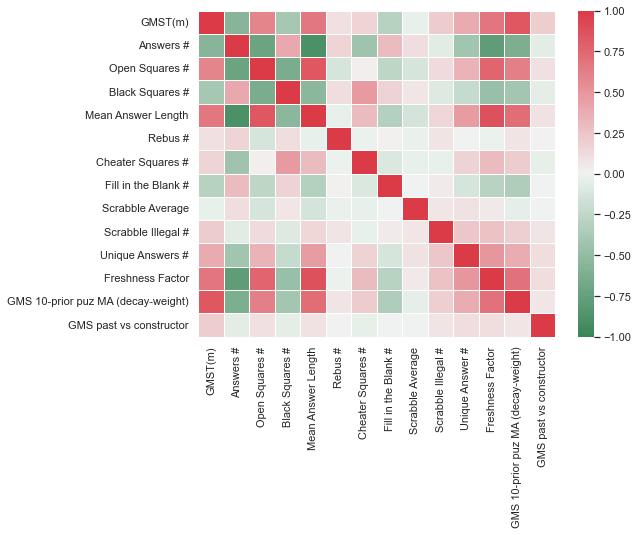

In [64]:
# 15x15 Puzzles Features Correlation to Global Median Solver Raw Solve Times Heat Map

GMS_15x15 = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]
puzzle_features = GMS_15x15[["GMST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "GMS_pds_l10_dw", 'GMS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'GMST(m)':'GMST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Mean Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'GMS_pds_l10_dw': 'GMS 10-prior puz MA (decay-weight)',    
'GMS_per_constr_avg_past_diff_from_10pMA':'GMS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['GMST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Mean Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'GMS 10-prior puz MA (decay-weight)', 'GMS past vs constructor'])
#_= ans.set_yticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Recent Adj Perf', 'Past Perf vs Constructor(s)'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

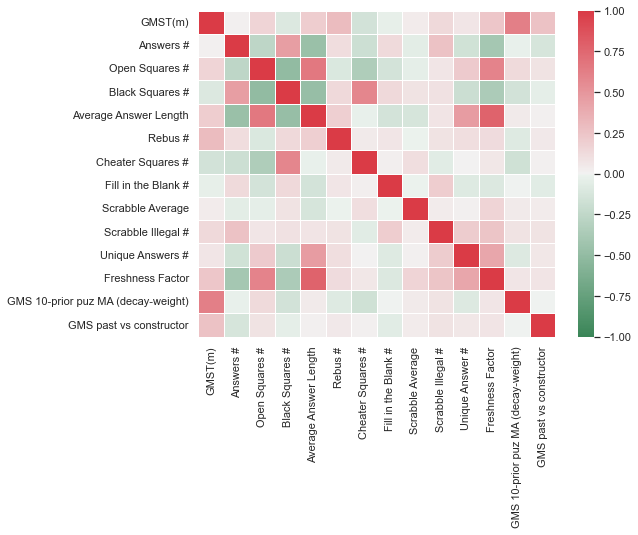

In [65]:
# 21x21 (Sunday) Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

GMS_21x21 = df_GMS.loc[df_GMS["DOW"]==("Sunday")]
puzzle_features = GMS_21x21[["GMST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "GMS_pds_l10_dw", 'GMS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'GMST(m)':'GMST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'GMS_pds_l10_dw': 'GMS 10-prior puz MA (decay-weight)',    
'GMS_per_constr_avg_past_diff_from_10pMA':'GMS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['GMST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'GMS 10-prior puz MA (decay-weight)', 'GMS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

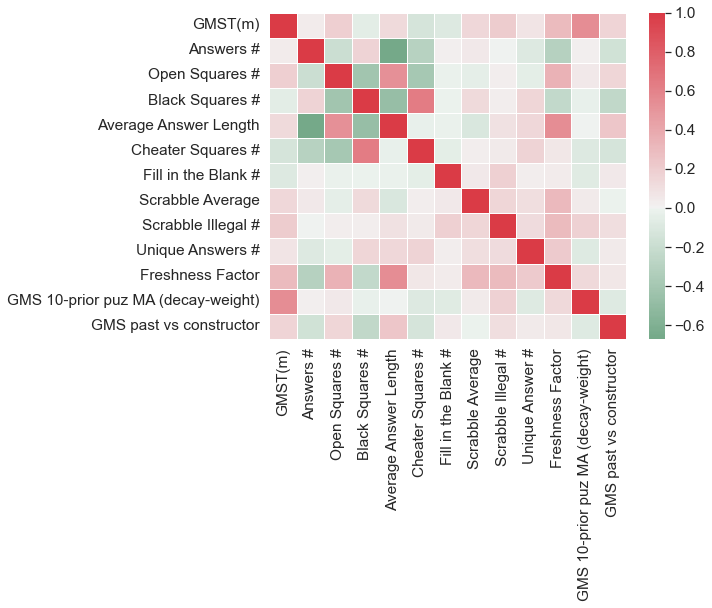

In [53]:
# Monday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

GMS_15x15 = df_GMS.loc[df_GMS["DOW"]==("Monday")]
puzzle_features = GMS_15x15[["GMST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "GMS_pds_l10_dw", 'GMS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'GMST(m)':'GMST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',     
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'GMS_pds_l10_dw': 'GMS 10-prior puz MA (decay-weight)',    
'GMS_per_constr_avg_past_diff_from_10pMA':'GMS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['GMST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'GMS 10-prior puz MA (decay-weight)', 'GMS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

In [ ]:
df_GMS_Mon.info()

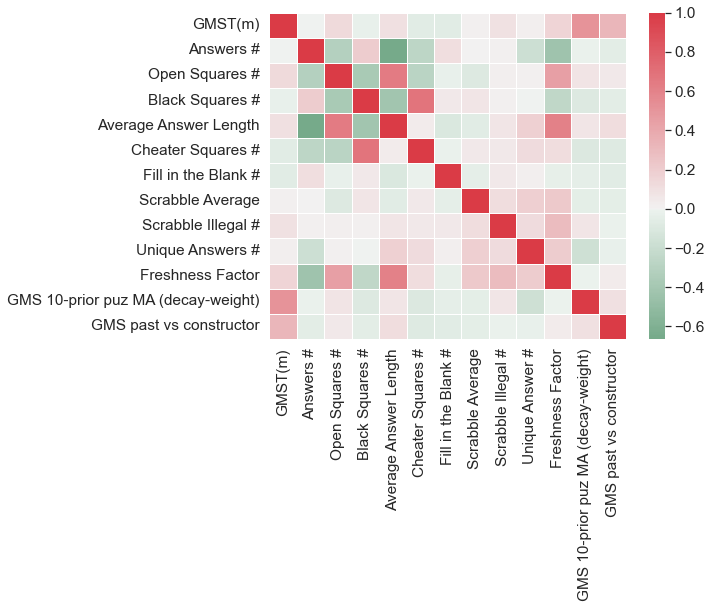

In [54]:
# Tuesday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

GMS_15x15 = df_GMS.loc[df_GMS["DOW"]==("Tuesday")]
puzzle_features = GMS_15x15[["GMST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "GMS_pds_l10_dw", 'GMS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'GMST(m)':'GMST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',     
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'GMS_pds_l10_dw': 'GMS 10-prior puz MA (decay-weight)',    
'GMS_per_constr_avg_past_diff_from_10pMA':'GMS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['GMST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'GMS 10-prior puz MA (decay-weight)', 'GMS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

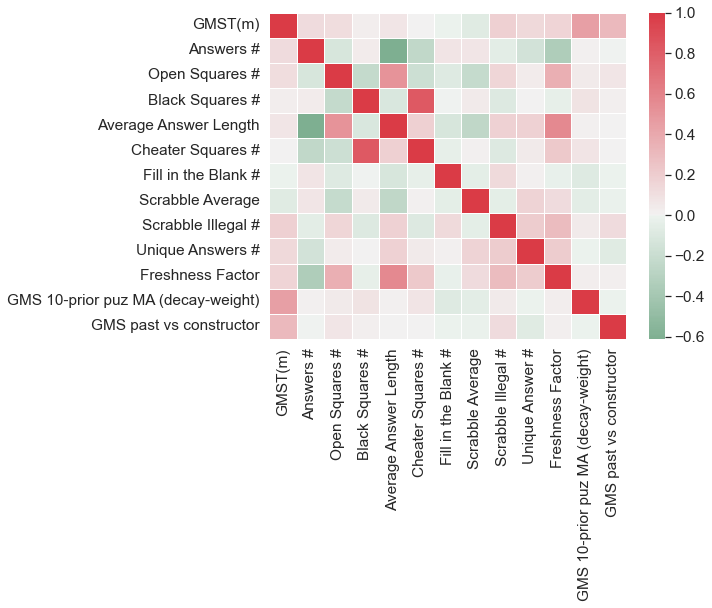

In [55]:
# Wednesday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

GMS_15x15 = df_GMS.loc[df_GMS["DOW"]==("Wednesday")]
puzzle_features = GMS_15x15[["GMST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "GMS_pds_l10_dw", 'GMS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'GMST(m)':'GMST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',     
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'GMS_pds_l10_dw': 'GMS 10-prior puz MA (decay-weight)',    
'GMS_per_constr_avg_past_diff_from_10pMA':'GMS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['GMST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'GMS 10-prior puz MA (decay-weight)', 'GMS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

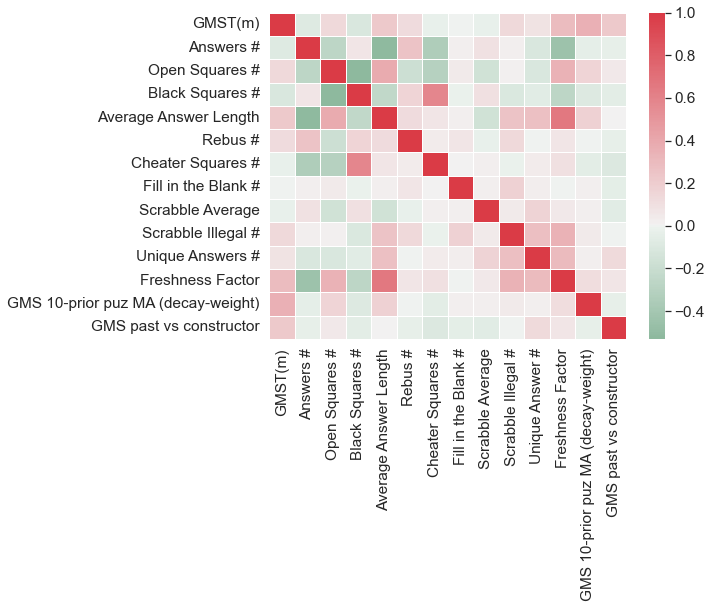

In [56]:
# Thursday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

GMS_15x15 = df_GMS.loc[df_GMS["DOW"]==("Thursday")]
puzzle_features = GMS_15x15[["GMST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "GMS_pds_l10_dw", 'GMS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'GMST(m)':'GMST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'GMS_pds_l10_dw': 'GMS 10-prior puz MA (decay-weight)',    
'GMS_per_constr_avg_past_diff_from_10pMA':'GMS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['GMST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'GMS 10-prior puz MA (decay-weight)', 'GMS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

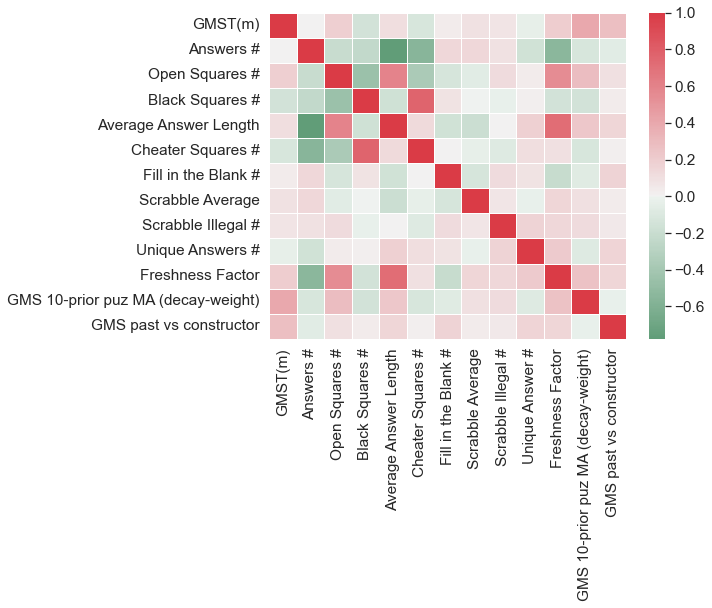

In [57]:
# Friday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

GMS_15x15 = df_GMS.loc[df_GMS["DOW"]==("Friday")]
puzzle_features = GMS_15x15[["GMST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "GMS_pds_l10_dw", 'GMS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'GMST(m)':'GMST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',     
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'GMS_pds_l10_dw': 'GMS 10-prior puz MA (decay-weight)',    
'GMS_per_constr_avg_past_diff_from_10pMA':'GMS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['GMST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'GMS 10-prior puz MA (decay-weight)', 'GMS past vs constructor'])

#save image 
# figure = ans.get_figure()    

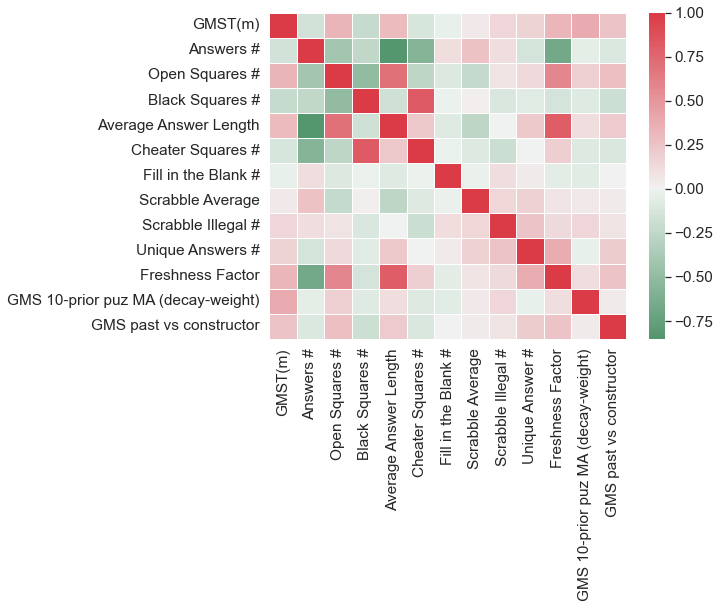

In [58]:
# Saturday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

GMS_15x15 = df_GMS.loc[df_GMS["DOW"]==("Saturday")]
puzzle_features = GMS_15x15[["GMST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "GMS_pds_l10_dw", 'GMS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'GMST(m)':'GMST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',     
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'GMS_pds_l10_dw': 'GMS 10-prior puz MA (decay-weight)',    
'GMS_per_constr_avg_past_diff_from_10pMA':'GMS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True)

_= ans.set_xticklabels(['GMST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'GMS 10-prior puz MA (decay-weight)', 'GMS past vs constructor'])

#save image 
# figure = ans.get_figure()    

### Scatterplots of Relationship of Grid and Answer Parameters to GMS Performance

In [ ]:
df_GMS.info()

In [59]:
# Create new df with all rows copied and placed below current rows. 
# This is so we can plot all 15x15 data together as a subplot in the figures below

df_GMS_copy = df_GMS.loc[(df_GMS["DOW_num"] != 1)] #15x15 only
df_GMS_copy["DOW_num"] = 0

df_GMS2 = pd.concat([df_GMS, df_GMS_copy],ignore_index=True)

In [ ]:
df_GMS2.info()

In [ ]:
df_GMS2["DOW_num"].unique()

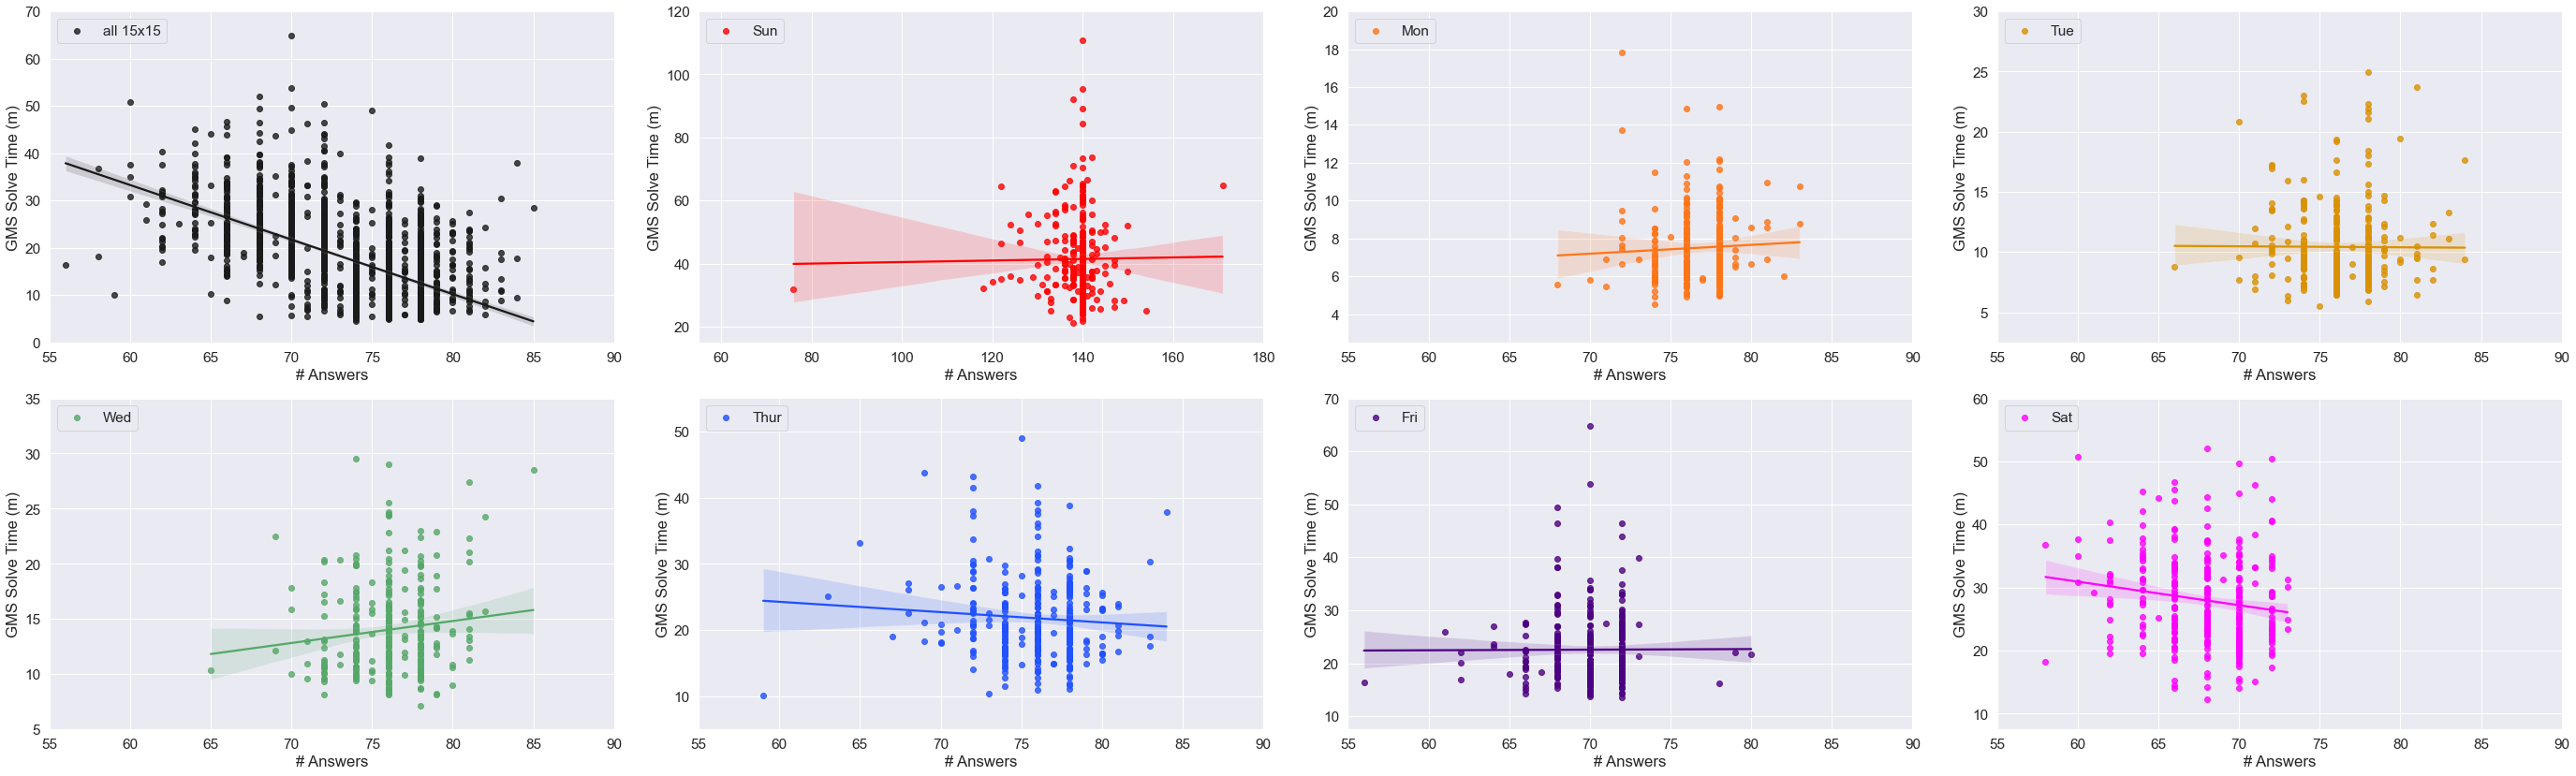

In [60]:
# Number of Answers vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Words", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Answers",
    ylabel="GMS Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((55,90))
p.axes[1].set_xlim((55,180))
p.axes[2].set_xlim((55,90))
p.axes[3].set_xlim((55,90))
p.axes[4].set_xlim((55,90))
p.axes[5].set_xlim((55,90))
p.axes[6].set_xlim((55,90))
p.axes[7].set_xlim((55,90))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [67]:
# Calculate Pearson R for 15x15 grids for this feature
GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Words']))

-0.5622901739491712


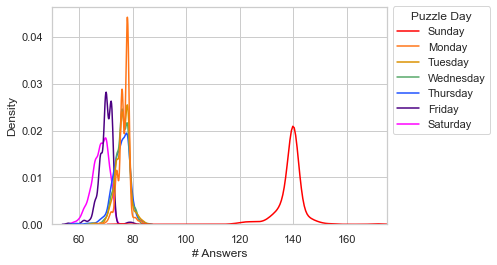

In [61]:
# Density plot of number of answers in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Words", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(50, 175)
ax.set_xlabel("# Answers")
plt.show()

In [ ]:
df_GMS["Words"].agg(['min', 'max'])

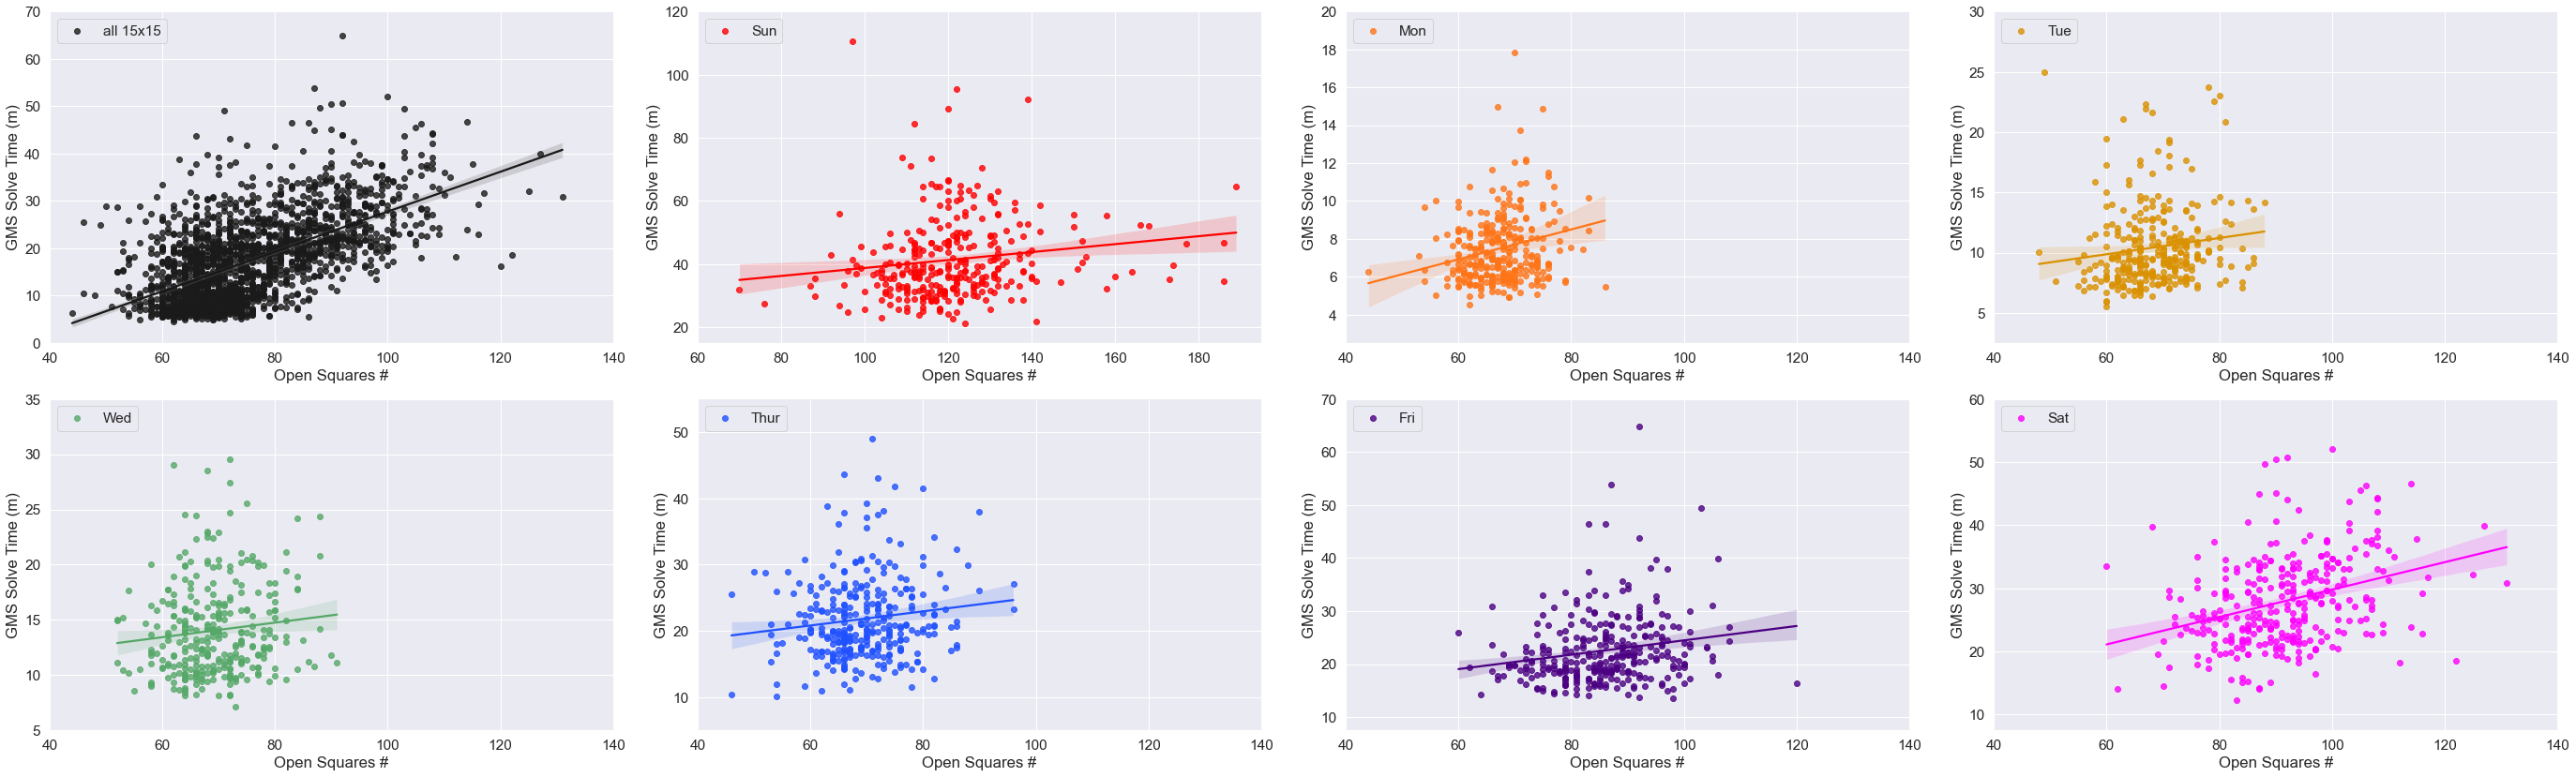

In [62]:
# Open Squares vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Open_Squares", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Open Squares #",
    ylabel="GMS Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((40,140))
p.axes[1].set_xlim((60,195))
p.axes[2].set_xlim((40,140))
p.axes[3].set_xlim((40,140))
p.axes[4].set_xlim((40,140))
p.axes[5].set_xlim((40,140))
p.axes[6].set_xlim((40,140))
p.axes[7].set_xlim((40,140))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [68]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Open_Squares']))

0.5908617955517419


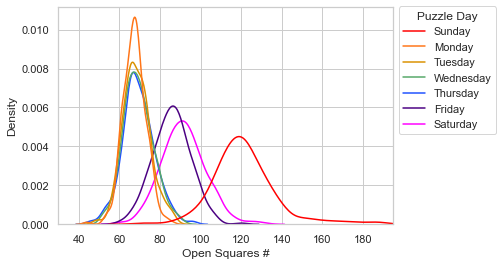

In [63]:
# Density plot of number of open squares in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Open_Squares", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(30, 195)
ax.set_xlabel("Open Squares #")
plt.show()

In [ ]:
df_GMS["Open_Squares"].agg(['min', 'max'])

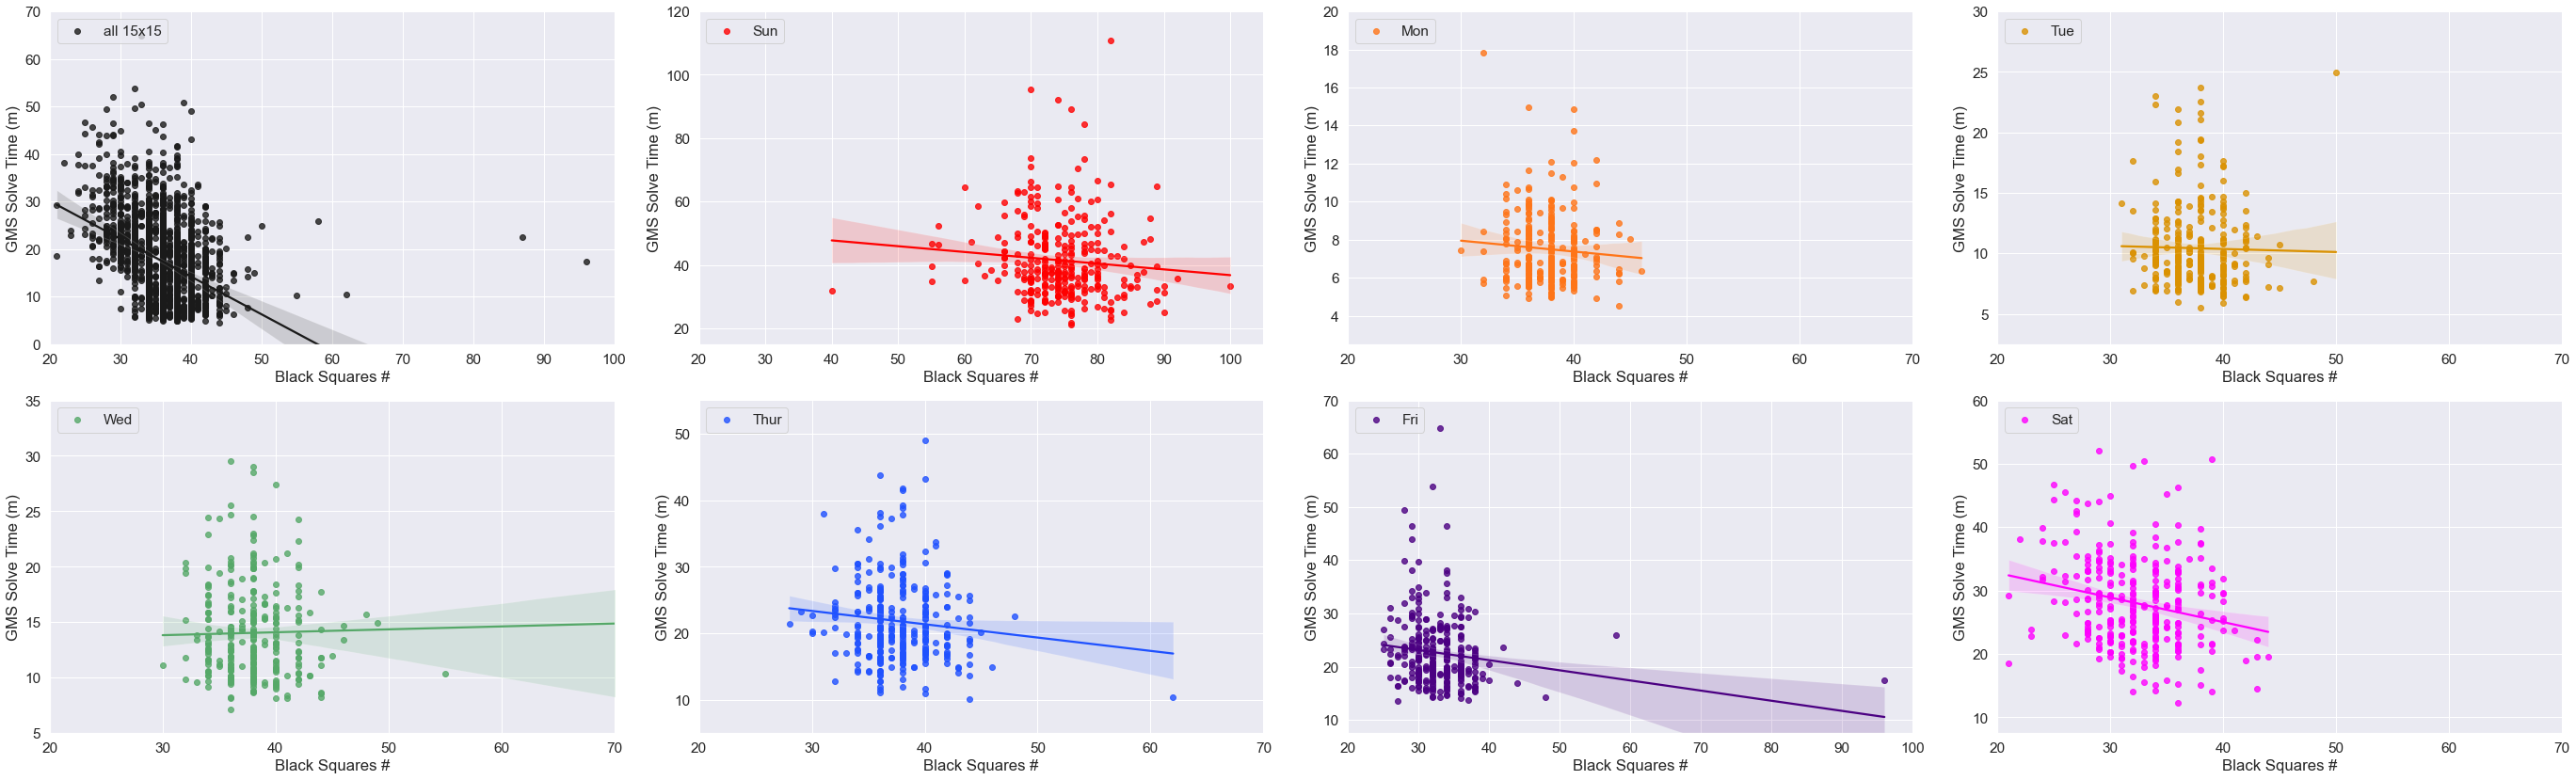

In [69]:
# Black Squares (blocks) vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Blocks", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Black Squares #",
    ylabel="GMS Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((20,100))
p.axes[1].set_xlim((20,105))
p.axes[2].set_xlim((20,70))
p.axes[3].set_xlim((20,70))
p.axes[4].set_xlim((20,70))
p.axes[5].set_xlim((20,70))
p.axes[6].set_xlim((20,100))
p.axes[7].set_xlim((20,70))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [72]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Blocks']))

-0.39495536792272146


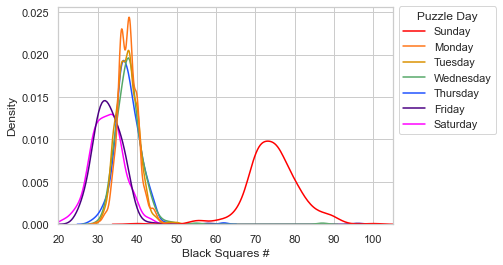

In [73]:
# Density plot of number of black squares (blocks) in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Blocks", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(20, 105)
ax.set_xlabel("Black Squares #")
plt.show()

In [ ]:
df_GMS["Blocks"].agg(['min', 'max'])

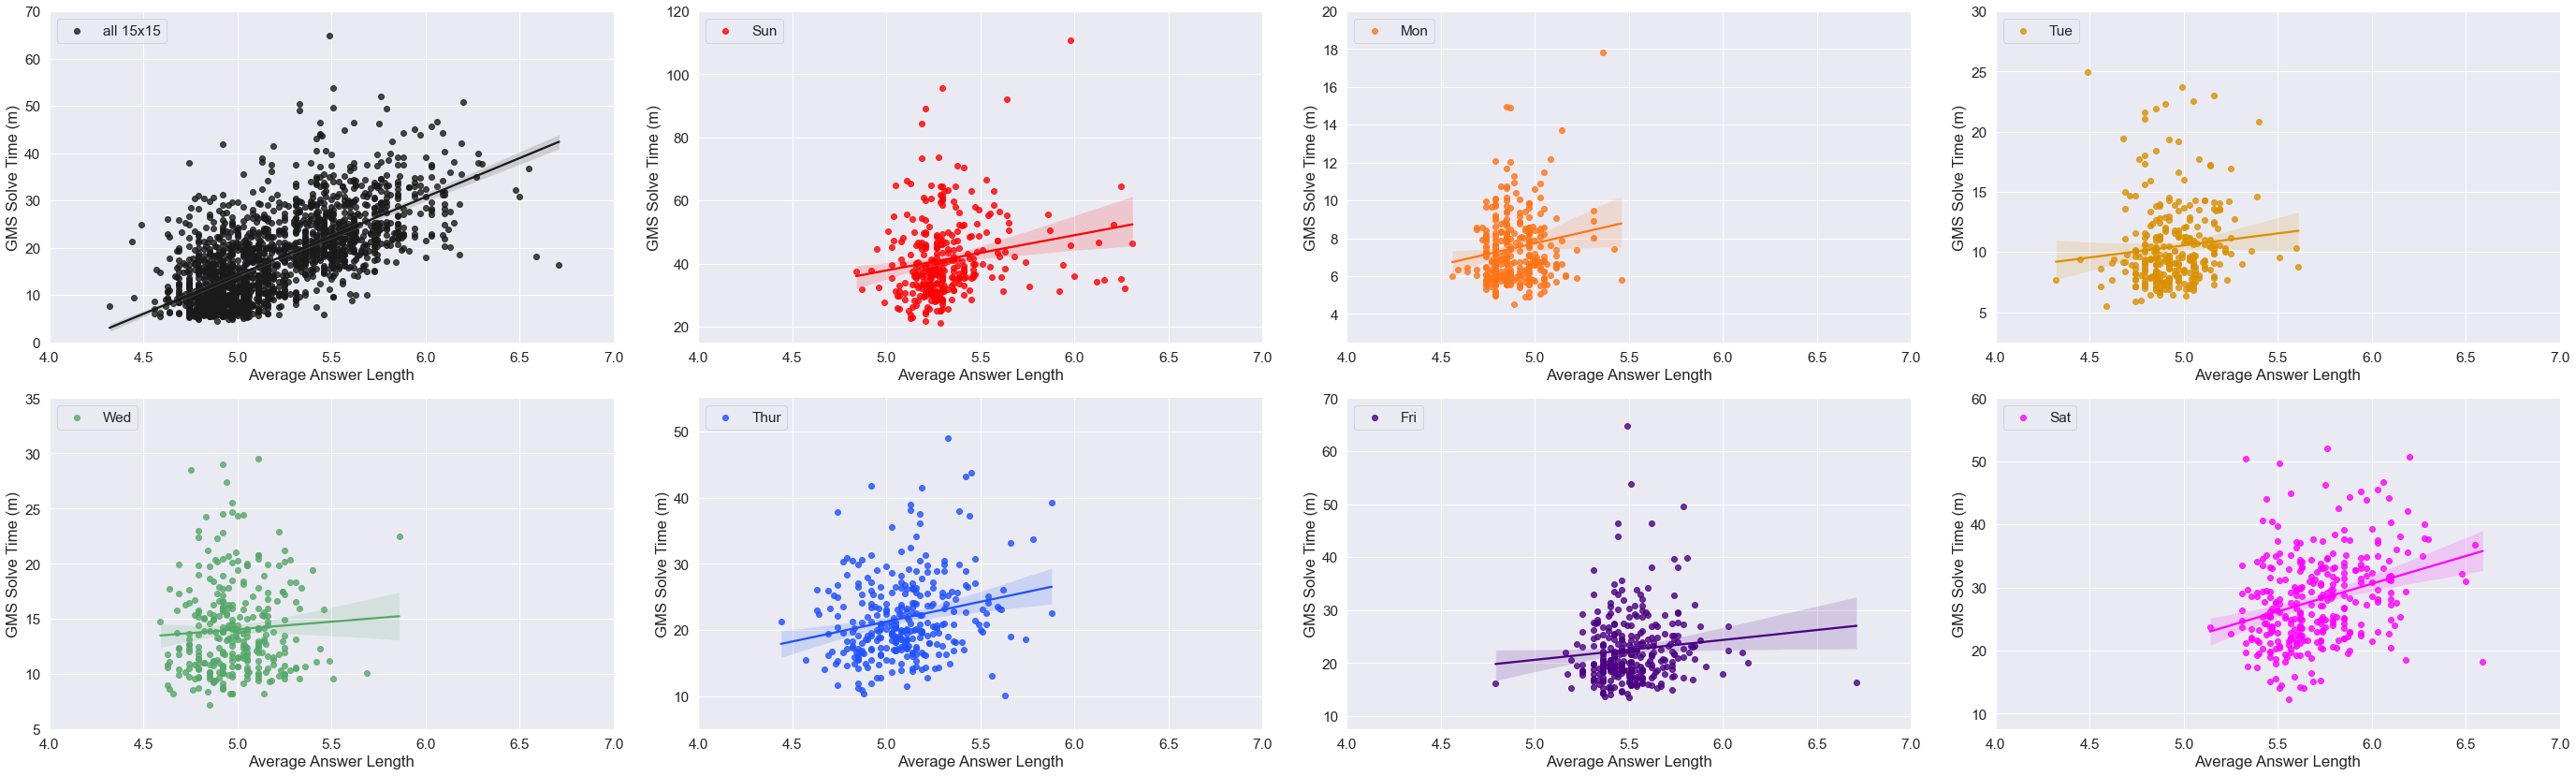

In [74]:
# Average Answer Length vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="AWL", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Average Answer Length",
    ylabel="GMS Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((4,7))
p.axes[1].set_xlim((4,7))
p.axes[2].set_xlim((4,7))
p.axes[3].set_xlim((4,7))
p.axes[4].set_xlim((4,7))
p.axes[5].set_xlim((4,7))
p.axes[6].set_xlim((4,7))
p.axes[7].set_xlim((4,7))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [75]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['AWL']))

0.6702121107972926


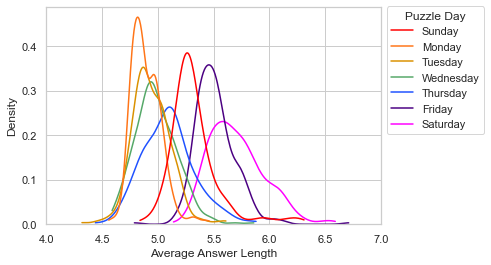

In [76]:
# Density plot of average answer length in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "AWL", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(3,7))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(4, 7)
ax.set_xlabel("Average Answer Length")
plt.show()

In [ ]:
df_GMS["AWL"].agg(['min', 'max'])

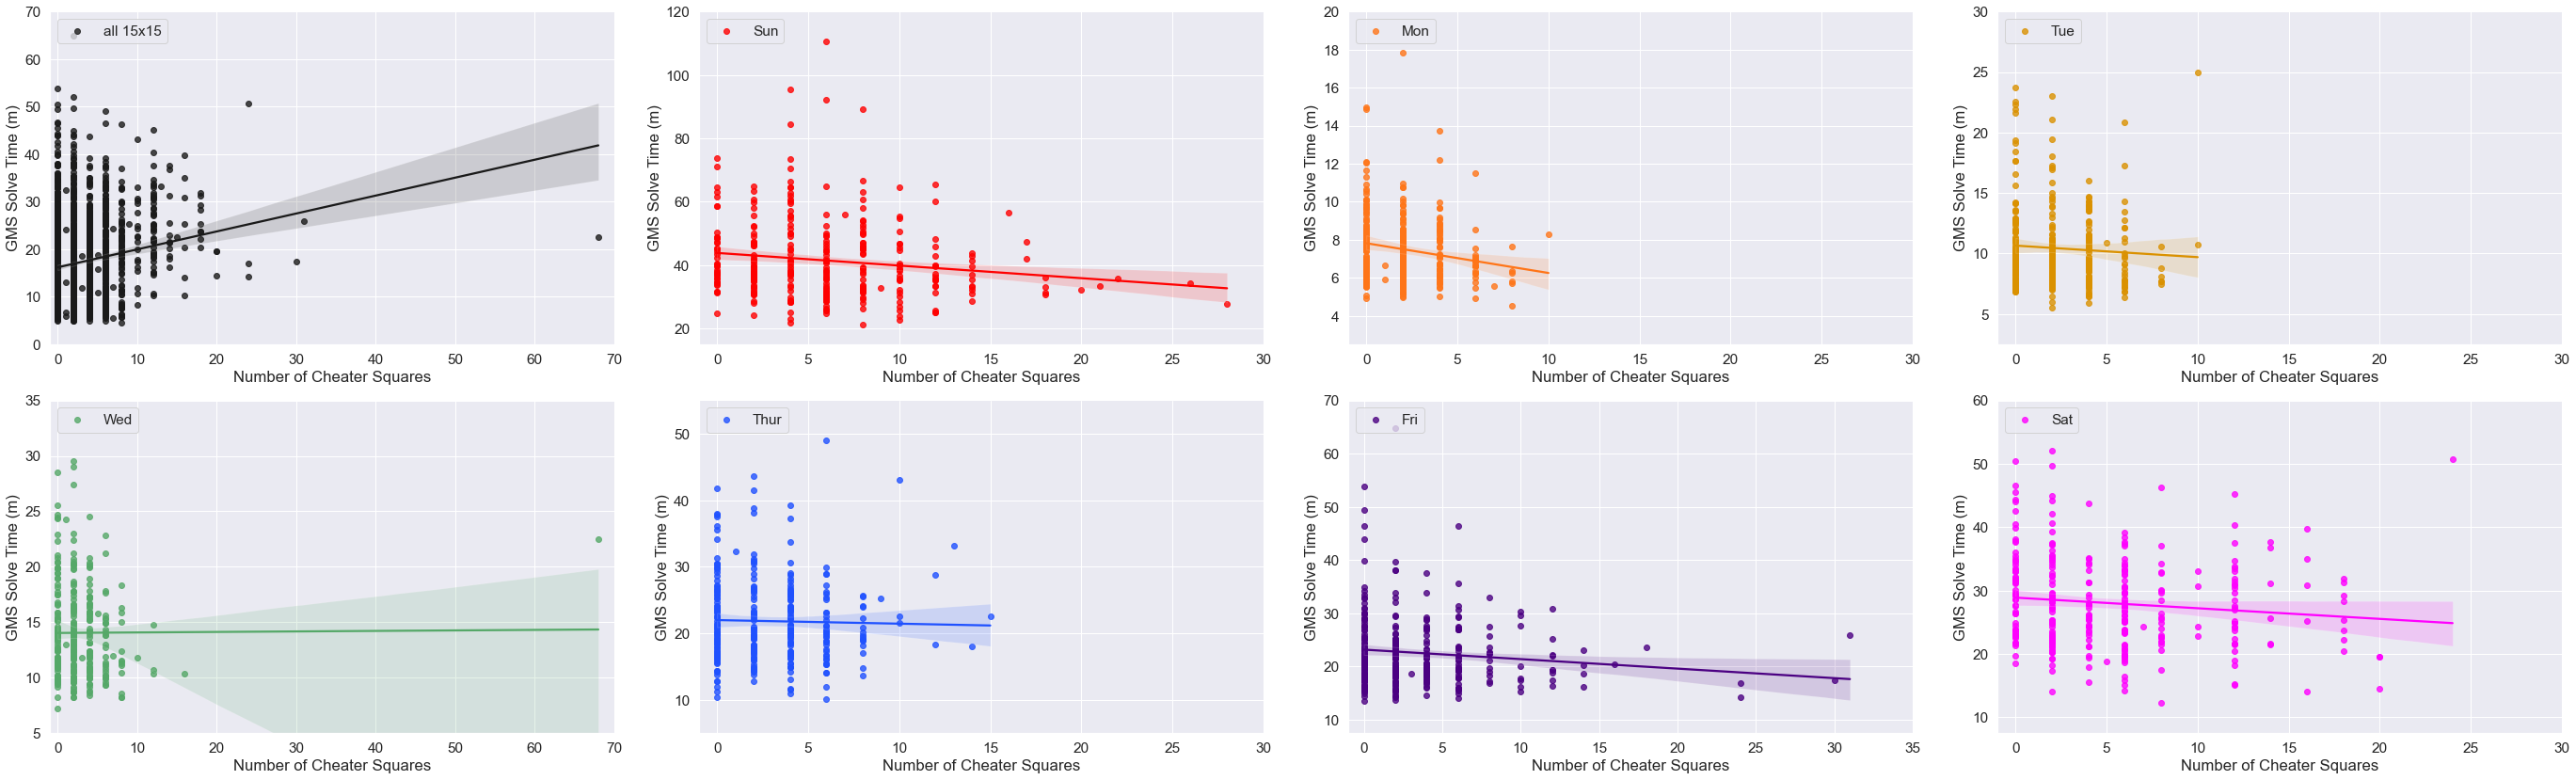

In [77]:
# Cheater Squares vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Cheater_Squares", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Number of Cheater Squares",
    ylabel="GMS Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,70))
p.axes[1].set_xlim((-1,30))
p.axes[2].set_xlim((-1,30))
p.axes[3].set_xlim((-1,30))
p.axes[4].set_xlim((-1,70))
p.axes[5].set_xlim((-1,30))
p.axes[6].set_xlim((-1,35))
p.axes[7].set_xlim((-1,30))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [78]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Cheater_Squares']))

0.16080732782737847


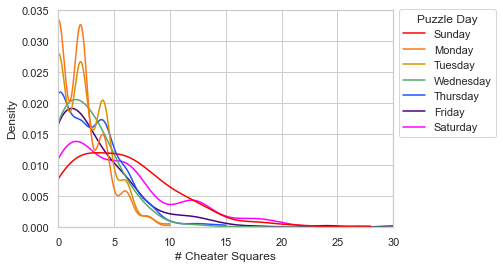

In [79]:
# Density plot of number of cheater squares in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Cheater_Squares", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(0, 30)
ax.set_xlabel("# Cheater Squares")
plt.show()

In [ ]:
df_GMS["Cheater_Squares"].agg(['min', 'max'])

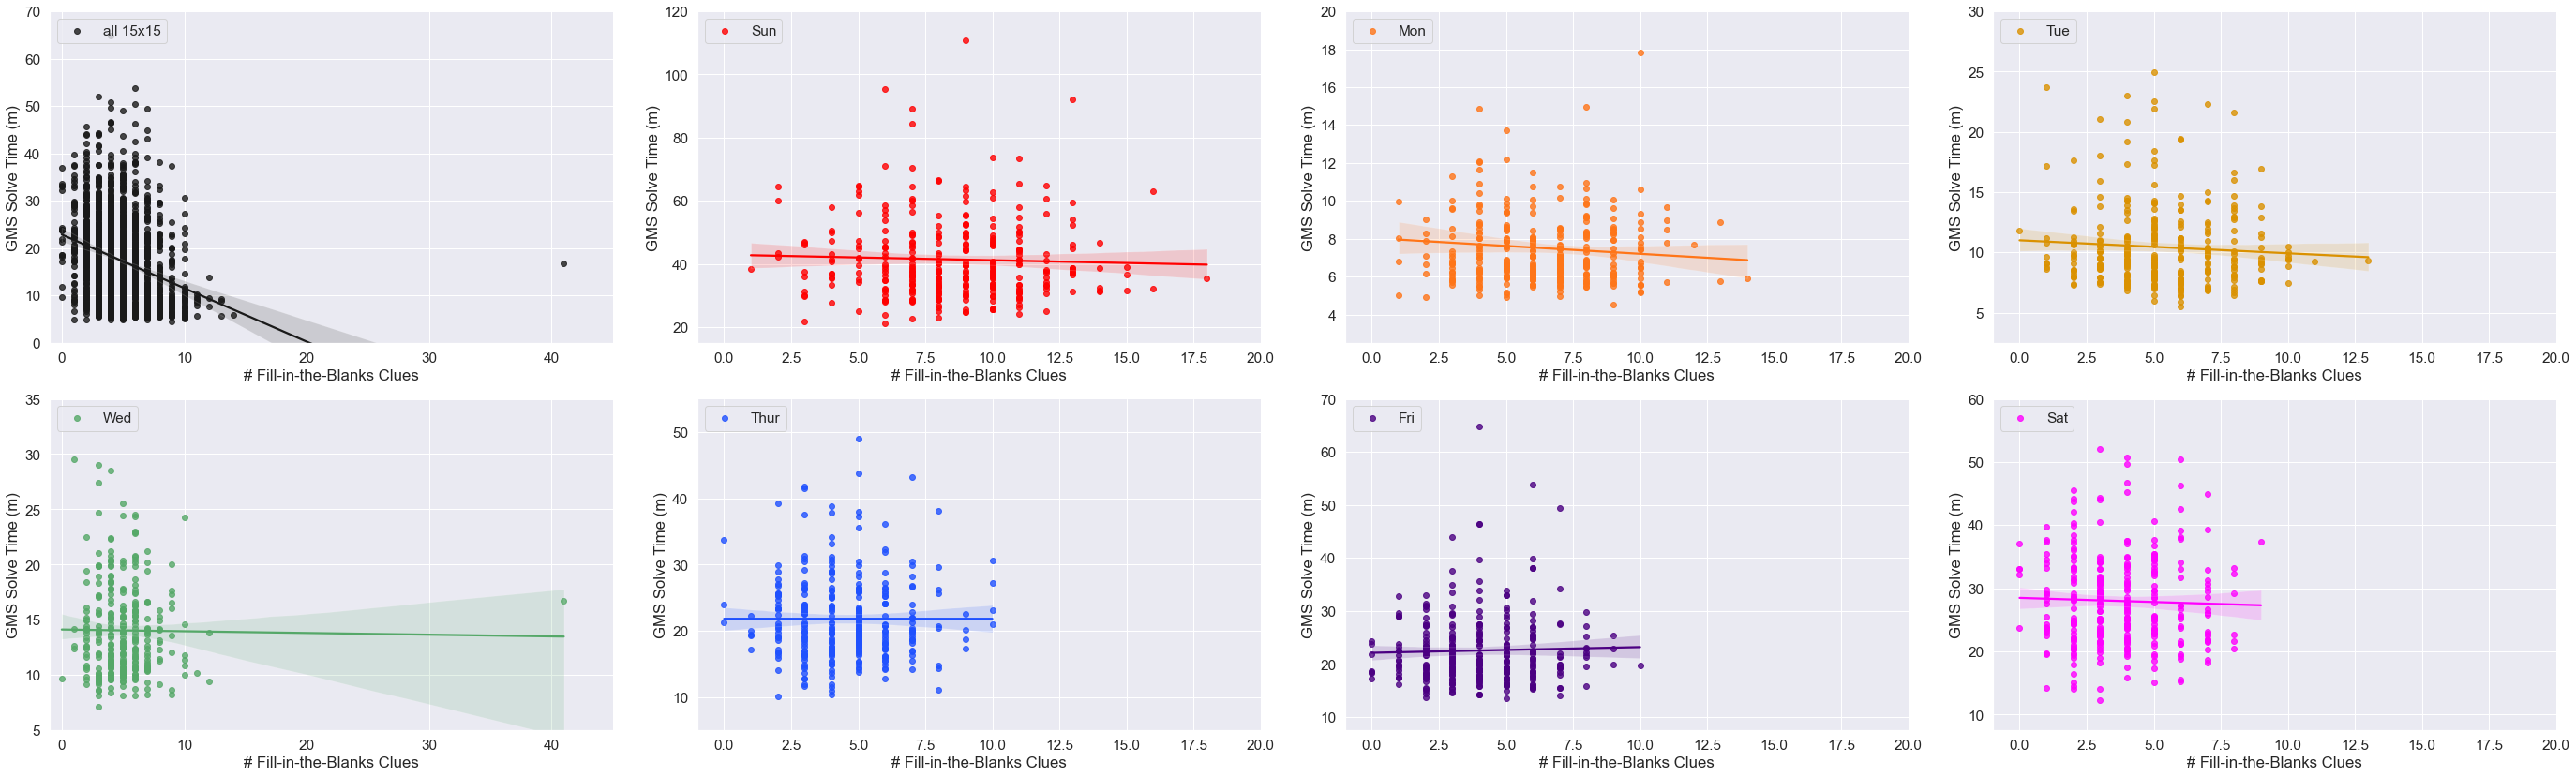

In [80]:
# Fill-in-the-blank answers vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="FITB", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Fill-in-the-Blanks Clues",
    ylabel="GMS Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,45))
p.axes[1].set_xlim((-1,20))
p.axes[2].set_xlim((-1,20))
p.axes[3].set_xlim((-1,20))
p.axes[4].set_xlim((-1,45))
p.axes[5].set_xlim((-1,20))
p.axes[6].set_xlim((-1,20))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [82]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['FITB']))

-0.29765911429928216


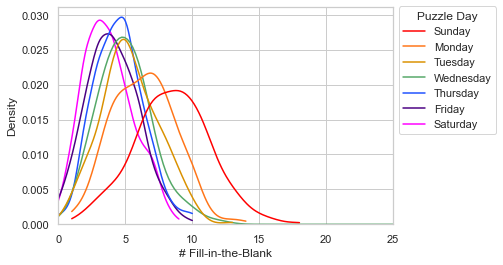

In [83]:
# Density plot of number of fill-in-the-blank clues in puzzles solved by IS1
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "FITB", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(0,45))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(0, 25)
ax.set_xlabel("# Fill-in-the-Blank")
plt.show()

In [ ]:
df_GMS["FITB"].agg(['min', 'max'])

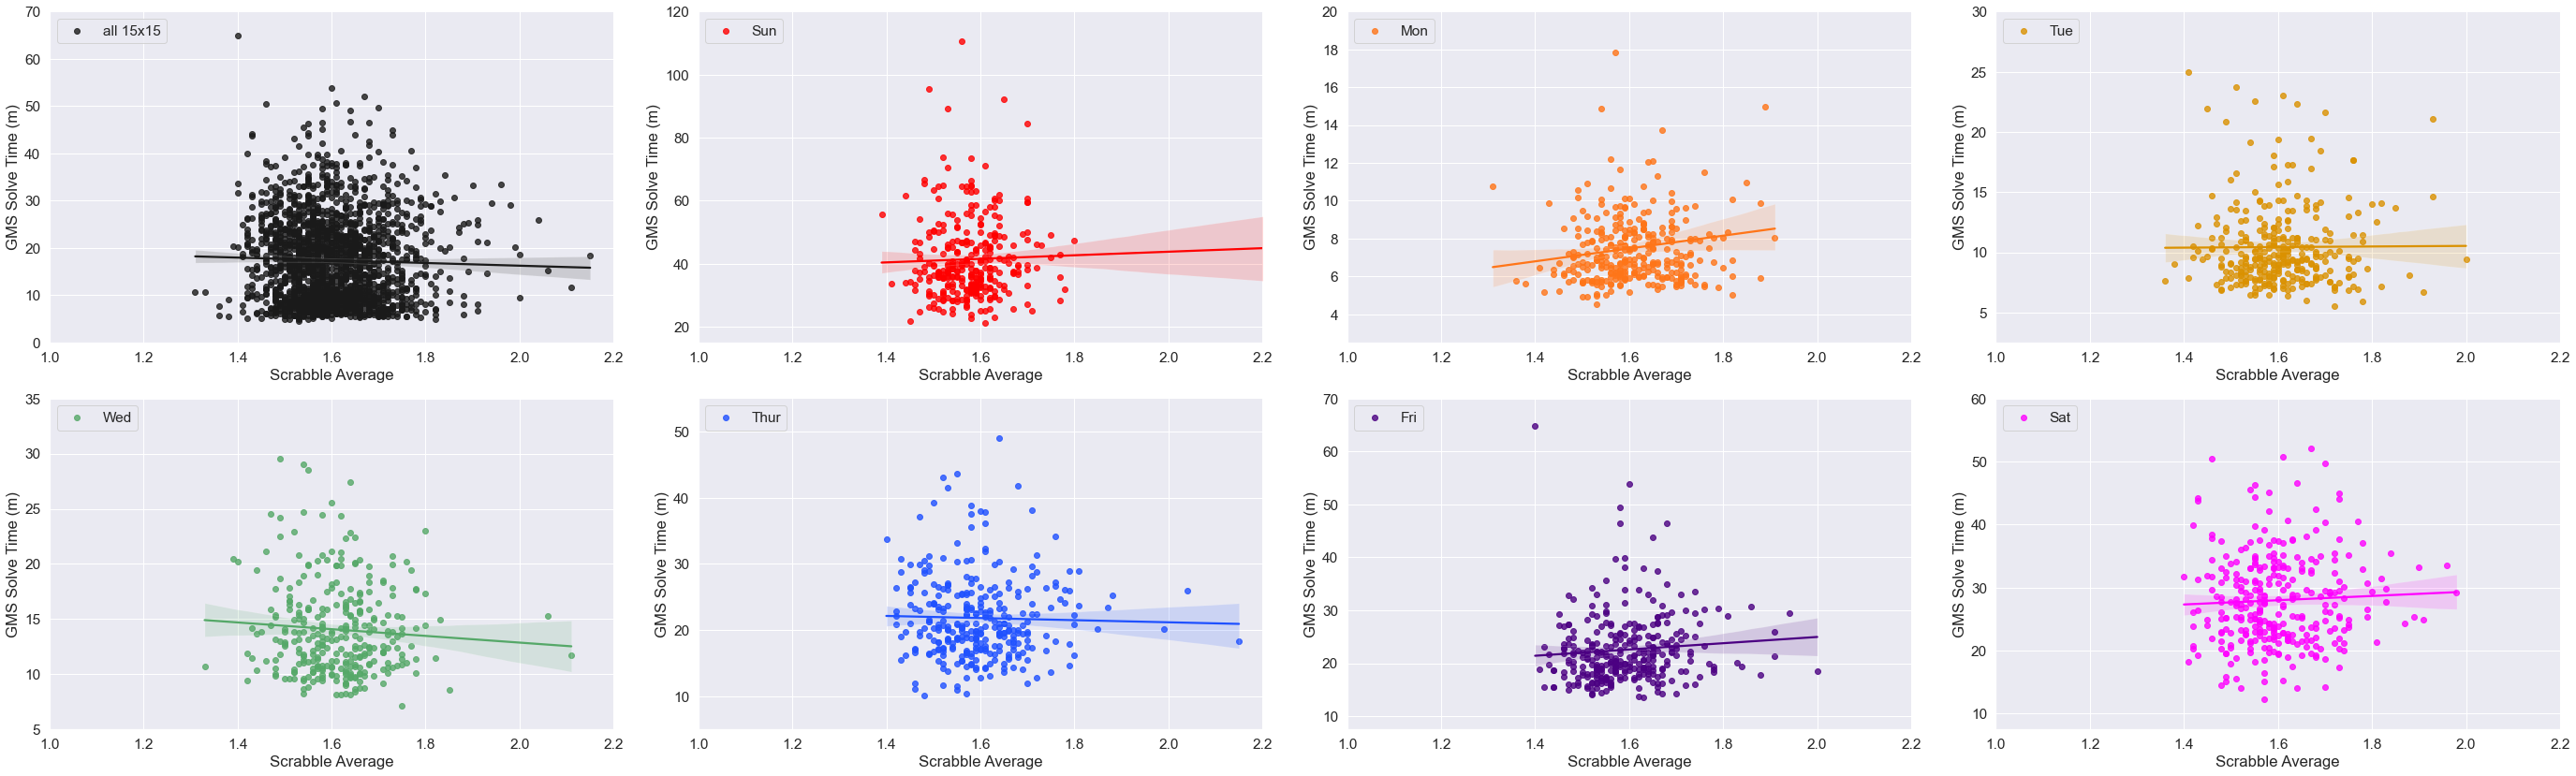

In [88]:
# Scrabble Average vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Scrabble_Avg", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Scrabble Average",
    ylabel="GMS Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((1,2.2))
p.axes[1].set_xlim((1,2.2))
p.axes[2].set_xlim((1,2.2))
p.axes[3].set_xlim((1,2.2))
p.axes[4].set_xlim((1,2.2))
p.axes[5].set_xlim((1,2.2))
p.axes[6].set_xlim((1,2.2))
p.axes[7].set_xlim((1,2.2))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [86]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Scrabble_Avg']))

-0.03110991874629975


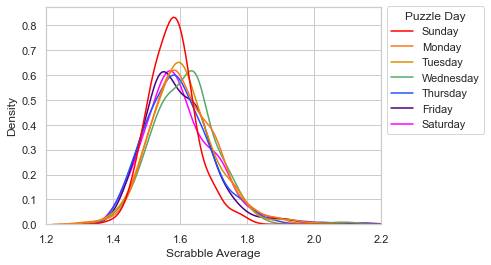

In [87]:
# Density plot of Scrabble Average in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Scrabble_Avg", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(1.2, 2.2)
ax.set_xlabel("Scrabble Average")
plt.show()

In [ ]:
df_GMS["Scrabble_Avg"].agg(['min', 'max'])

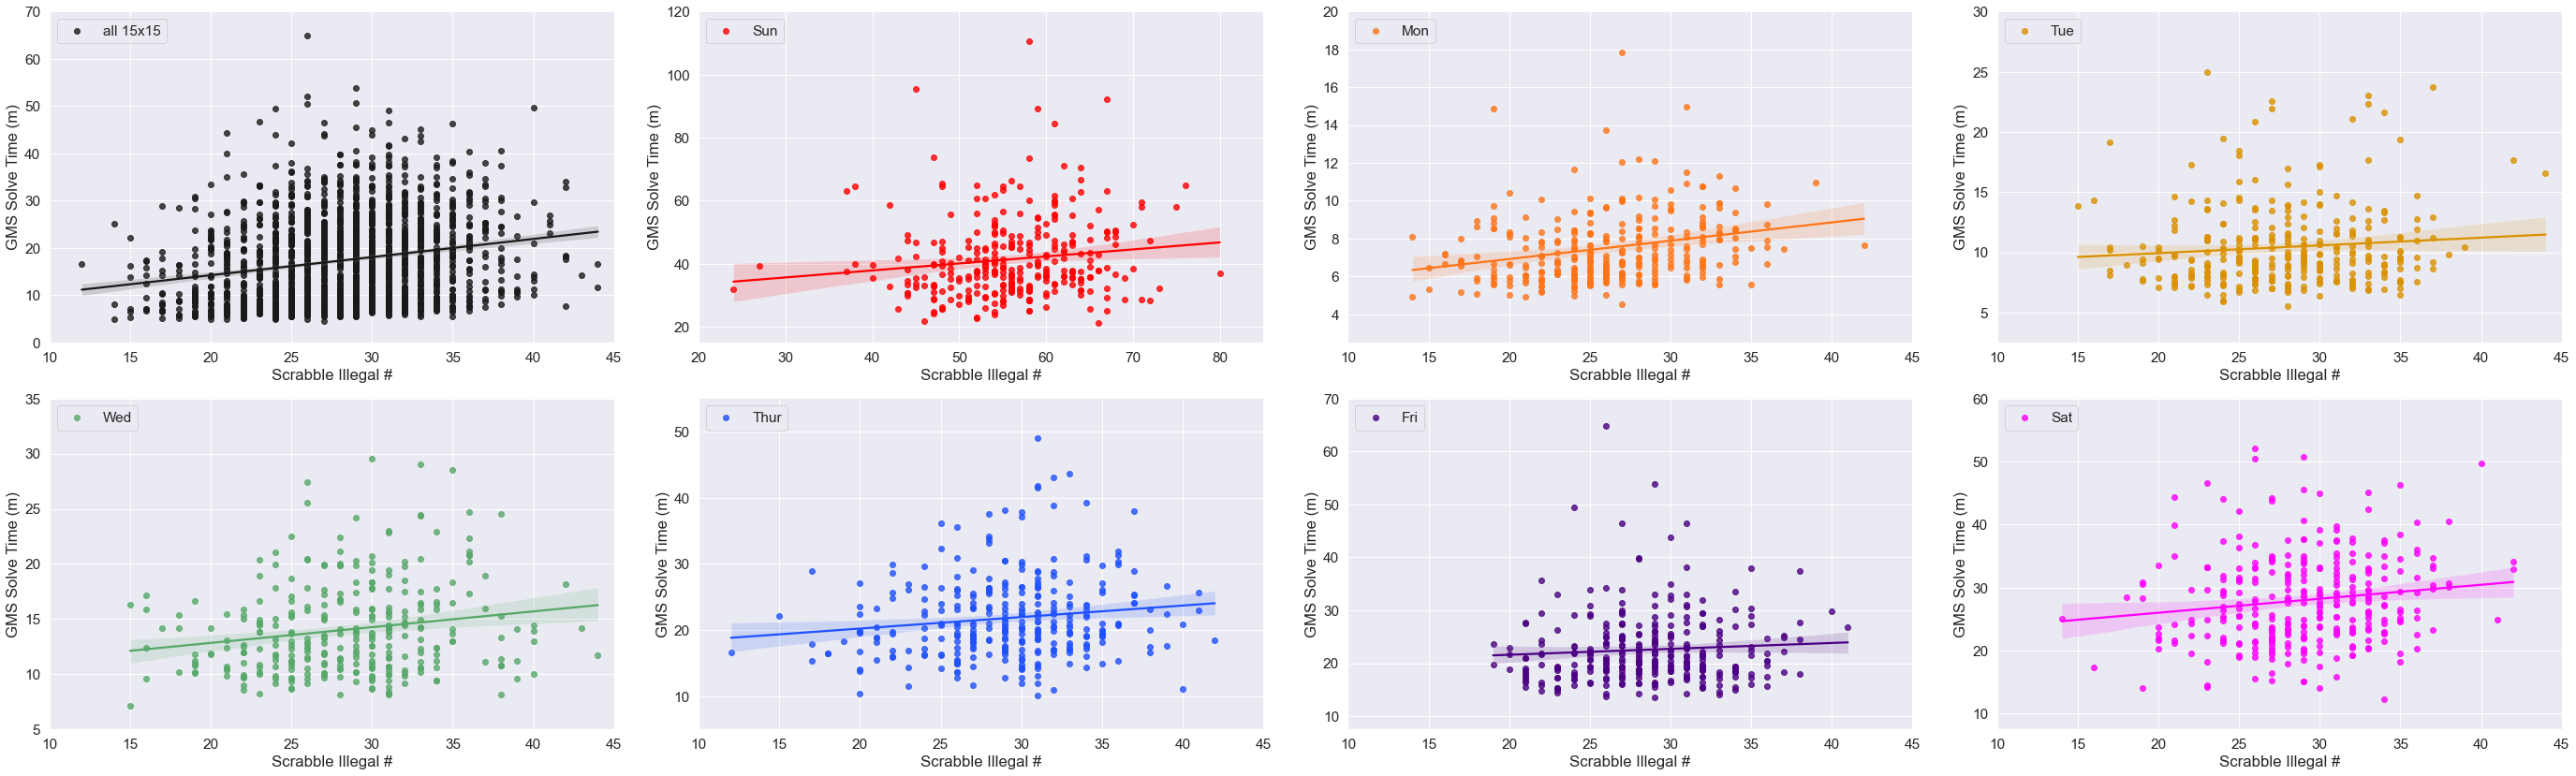

In [89]:
# Scrabble Illegal # vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Scrabble_Illegal", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Scrabble Illegal #",
    ylabel="GMS Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((10,45))
p.axes[1].set_xlim((20,85))
p.axes[2].set_xlim((10,45))
p.axes[3].set_xlim((10,45))
p.axes[4].set_xlim((10,45))
p.axes[5].set_xlim((10,45))
p.axes[6].set_xlim((10,45))
p.axes[7].set_xlim((10,45))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [90]:
# Calculate Pearson R for 15x15 grids for this feature
#GMS_no_Sun = df_GMS.loc[df_GMS["DOW"]!=("Sunday")]

print(GMS_no_Sun['GMST(m)'].corr(GMS_no_Sun['Scrabble_Illegal']))

0.20958011857614114


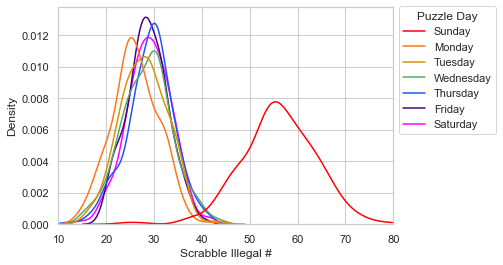

In [91]:
# Density plot of Scrabble Illegal # in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Scrabble_Illegal", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(10, 80)
ax.set_xlabel("Scrabble Illegal #")
plt.show()

In [ ]:
df_GMS["Scrabble_Illegal"].agg(['min', 'max'])

In [ ]:
# Unique Answers # # vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Unique_Answers", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Unique Answers #",
    ylabel="GMS Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,17.5))
p.axes[1].set_xlim((-1,25))
p.axes[2].set_xlim((-1,17.5))
p.axes[3].set_xlim((-1,17.5))
p.axes[4].set_xlim((-1,17.5))
p.axes[5].set_xlim((-1,17.5))
p.axes[6].set_xlim((-1,17.5))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [ ]:
# Density plot of Unique Answers # in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Unique_Answers", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(0,25))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(0, 25)
ax.set_xlabel("Unique Answers #")
plt.show()

In [ ]:
df_GMS["Unique_Answers"].agg(['min', 'max'])

In [ ]:
# Freshness Factor vs GMS Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="Freshness_Factor", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Freshness Factor",
    ylabel="GMS Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((10,95))
p.axes[1].set_xlim((10,95))
p.axes[2].set_xlim((10,95))
p.axes[3].set_xlim((10,95))
p.axes[4].set_xlim((10,95))
p.axes[5].set_xlim((10,95))
p.axes[6].set_xlim((10,95))
p.axes[7].set_xlim((10,95))

p.axes[0].set_ylim((0,70))
p.axes[1].set_ylim((15,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((5,35))
p.axes[5].set_ylim((5,55))
p.axes[6].set_ylim((7.5,70))
p.axes[7].set_ylim((7.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [ ]:
# Density plot of Freshness Factor in puzzles solved by GMS
# Rememember to use GMS because GMS2 has the copied-in data for plotting all completed puzzles together

df_GMS = df_GMS.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=df_GMS, x = "Freshness_Factor", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.027), title='Puzzle Day')

plt.xlim(10, 95)
ax.set_xlabel("Freshness Factor")
plt.show()

In [ ]:
df_GMS["Freshness_Factor"].agg(['min', 'max'])

In [ ]:
# IS1 Recent Past Performance (Time-Decay Weighted Immediately Previous 10 Puzzles Prior to a given puzzle) vs IS1 Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="GMS_pds_l10_dw", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "GMS Adjusted Recent Performance (m)",
    ylabel="GMS Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((2.5,60))
p.axes[1].set_xlim((10,100))
p.axes[2].set_xlim((2.5,20))
p.axes[3].set_xlim((2.5,30))
p.axes[4].set_xlim((2.5,35))
p.axes[5].set_xlim((2.5,55))
p.axes[6].set_xlim((2.5,60))
p.axes[7].set_xlim((2.5,60))

p.axes[0].set_ylim((2.5,60))
p.axes[1].set_ylim((10,100))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((2.5,35))
p.axes[5].set_ylim((2.5,55))
p.axes[6].set_ylim((2.5,60))
p.axes[7].set_ylim((2.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [ ]:
df_GMS.to_csv('../data/df_GMS.csv', index=False)

In [ ]:
# Mean Past Performance vs Constructor(s) vs IS1 Raw Solve Times

df_GMS2 = df_GMS2.sort_values(by=['DOW_num'], ascending = True)

df_GMS2['plot_seq_map'] = df_GMS2['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_GMS2, x="GMS_per_constr_avg_past_diff_from_10pMA", y="GMST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "GMS Past Performance vs Constructor(s) (Mean % Diff from 10pMA)",
    ylabel="GMS Individual Puzzle Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-75,75))
p.axes[1].set_xlim((-75,75))
p.axes[2].set_xlim((-75,75))
p.axes[3].set_xlim((-75,75))
p.axes[4].set_xlim((-75,75))
p.axes[5].set_xlim((-75,75))
p.axes[6].set_xlim((-75,75))
p.axes[7].set_xlim((-75,75))

p.axes[0].set_ylim((2.5,60))
p.axes[1].set_ylim((10,100))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,30))
p.axes[4].set_ylim((2.5,35))
p.axes[5].set_ylim((2.5,55))
p.axes[6].set_ylim((2.5,60))
p.axes[7].set_ylim((2.5,60))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')